<a href="https://colab.research.google.com/github/zolo012/Machine_learning/blob/main/Stroke_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke prediction

Creator: Bereczki Zoltán

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import statsmodels.api as sm
import statistics
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, RocCurveDisplay, confusion_matrix, roc_auc_score, roc_curve
import io


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data (1).csv


In [ ]:
# Load stroke data

stroke_df = pd.read_csv(io.BytesIO(uploaded['healthcare-dataset-stroke-data.csv']))
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [ ]:
# Check duplicates
stroke_df.duplicated().sum()


0

In [ ]:
# Missing values
stroke_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

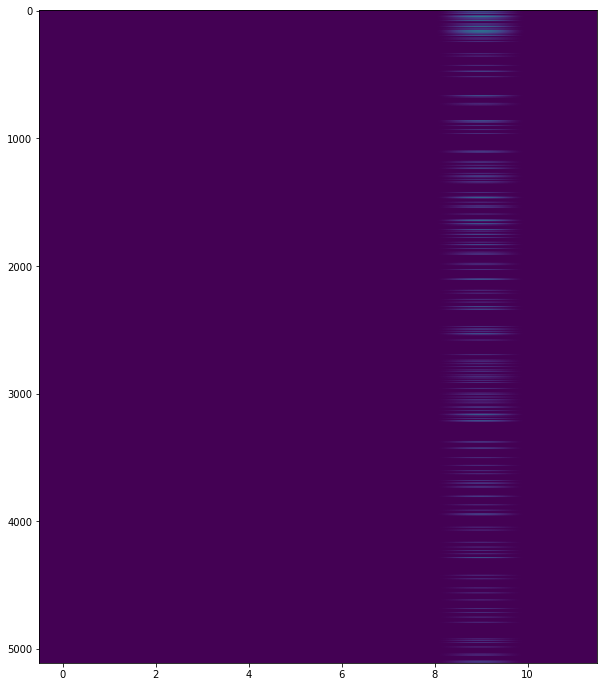

In [ ]:
# Visualize missing values
plt.figure(figsize=(10, 12))
plt.imshow(stroke_df.isna(), aspect='auto')

There are only missing values in bmi. There's not so much data, thus I can't delete those samples fro which BMI isn't known. The best way is to replace missing values with columnwise mean.

In [ ]:
# Set 'id' column as index
stroke_df.set_index('id', inplace=True)
stroke_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [ ]:
# Column types
stroke_df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [ ]:
# Replace missing values with mean
stroke_df['bmi'] = stroke_df['bmi'].replace(np.NaN, stroke_df['bmi'].mean())
stroke_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0


In [ ]:
# Check missing values handled properly
stroke_df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

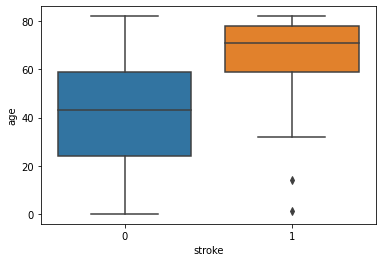

In [ ]:
# Relationship between age and stroke

sns.boxplot(x=stroke_df['stroke'], y=stroke_df['age'])

The older people have stroke with higher chance.

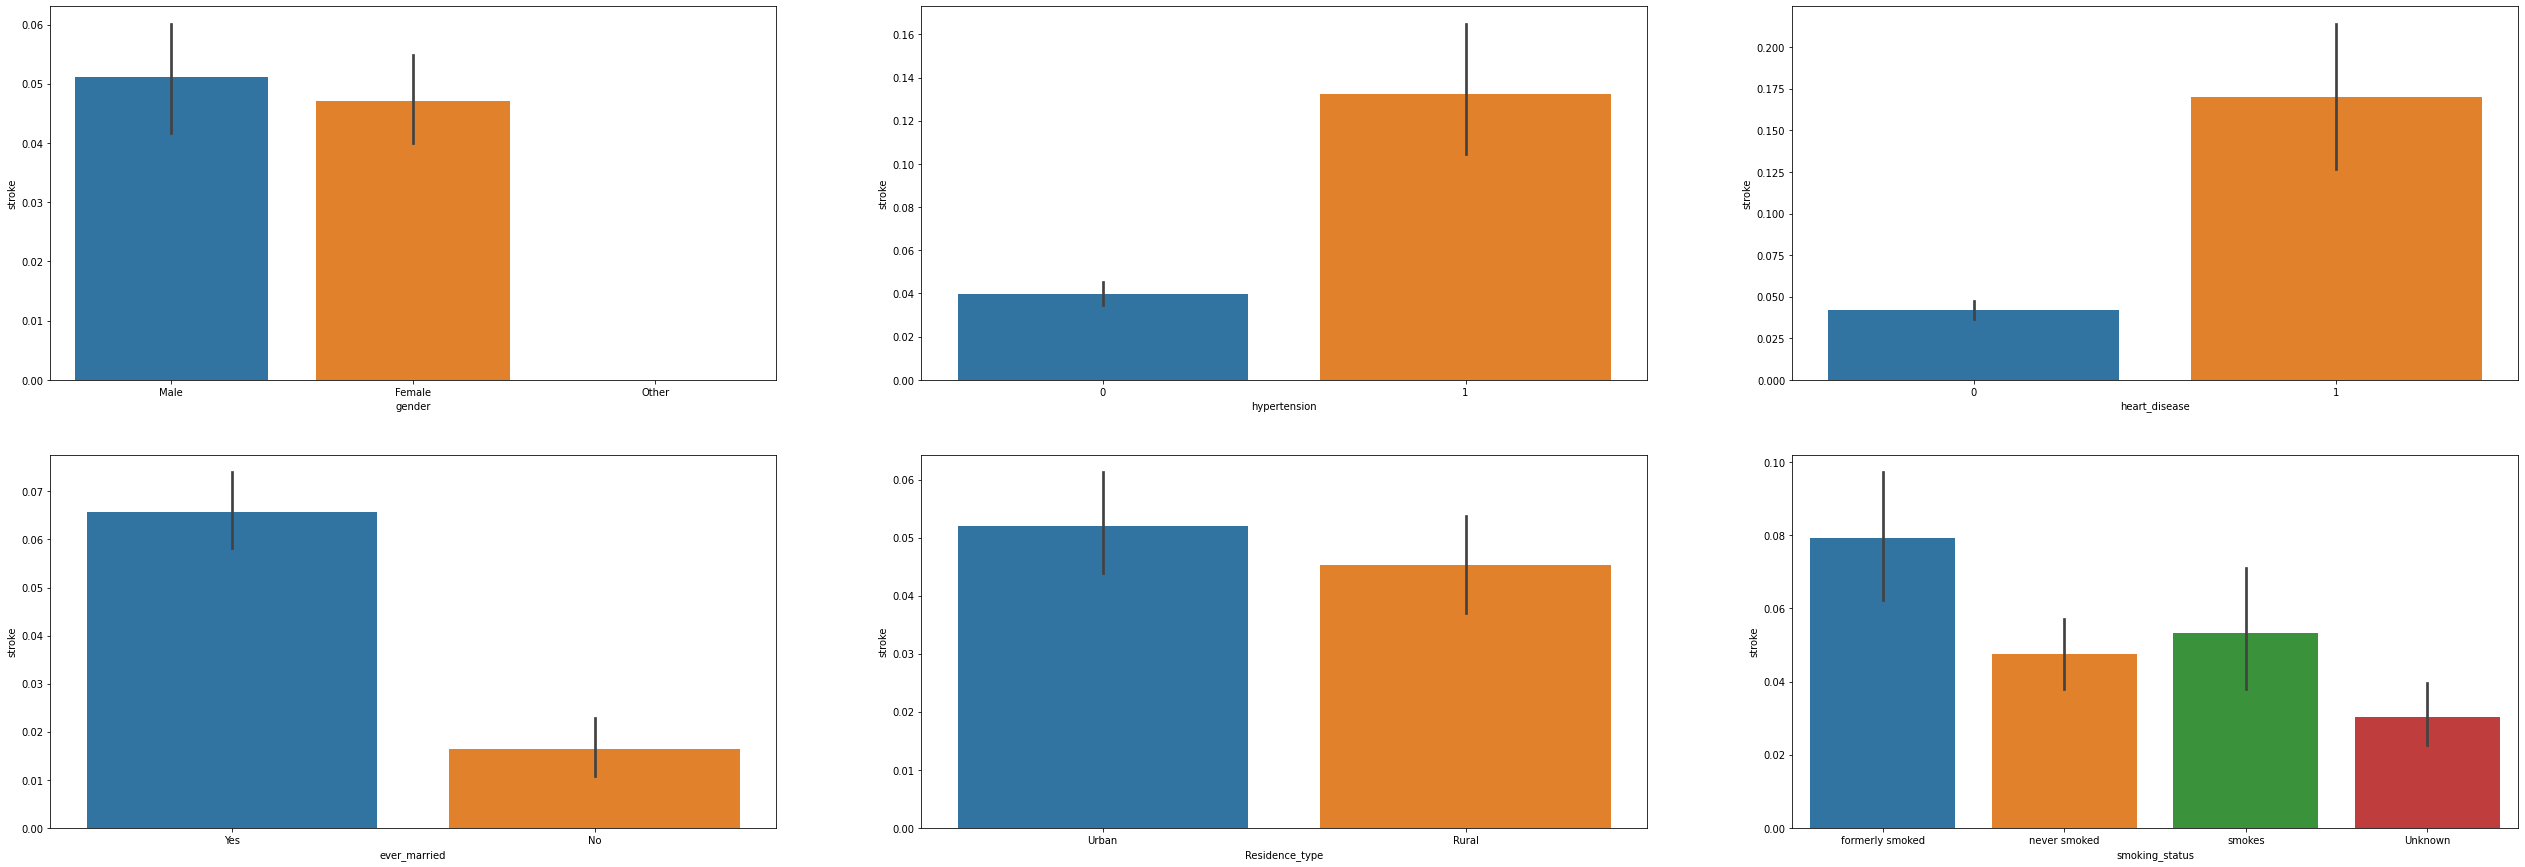

In [ ]:
# Plot barplots of gender, hypertension, heart disease, ever married, residence type and smoking status in terms of stroke
fig, ax = plt.subplots(2, 3, figsize=(35, 12))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)


sns.barplot(data=stroke_df, x='gender', y='stroke', ax=ax[0][0])
sns.barplot(data=stroke_df, x='hypertension', y='stroke', ax=ax[0][1])
sns.barplot(data=stroke_df, x='heart_disease', y='stroke', ax=ax[0][2])
sns.barplot(data=stroke_df, x='ever_married', y='stroke', ax=ax[1][0])
sns.barplot(data=stroke_df, x='Residence_type', y='stroke', ax=ax[1][1])
#sns.barplot(data=stroke_df, x='work_type', y='stroke', ax=ax[1][0])
sns.barplot(data=stroke_df, x='smoking_status', y='stroke', ax=ax[1][2])



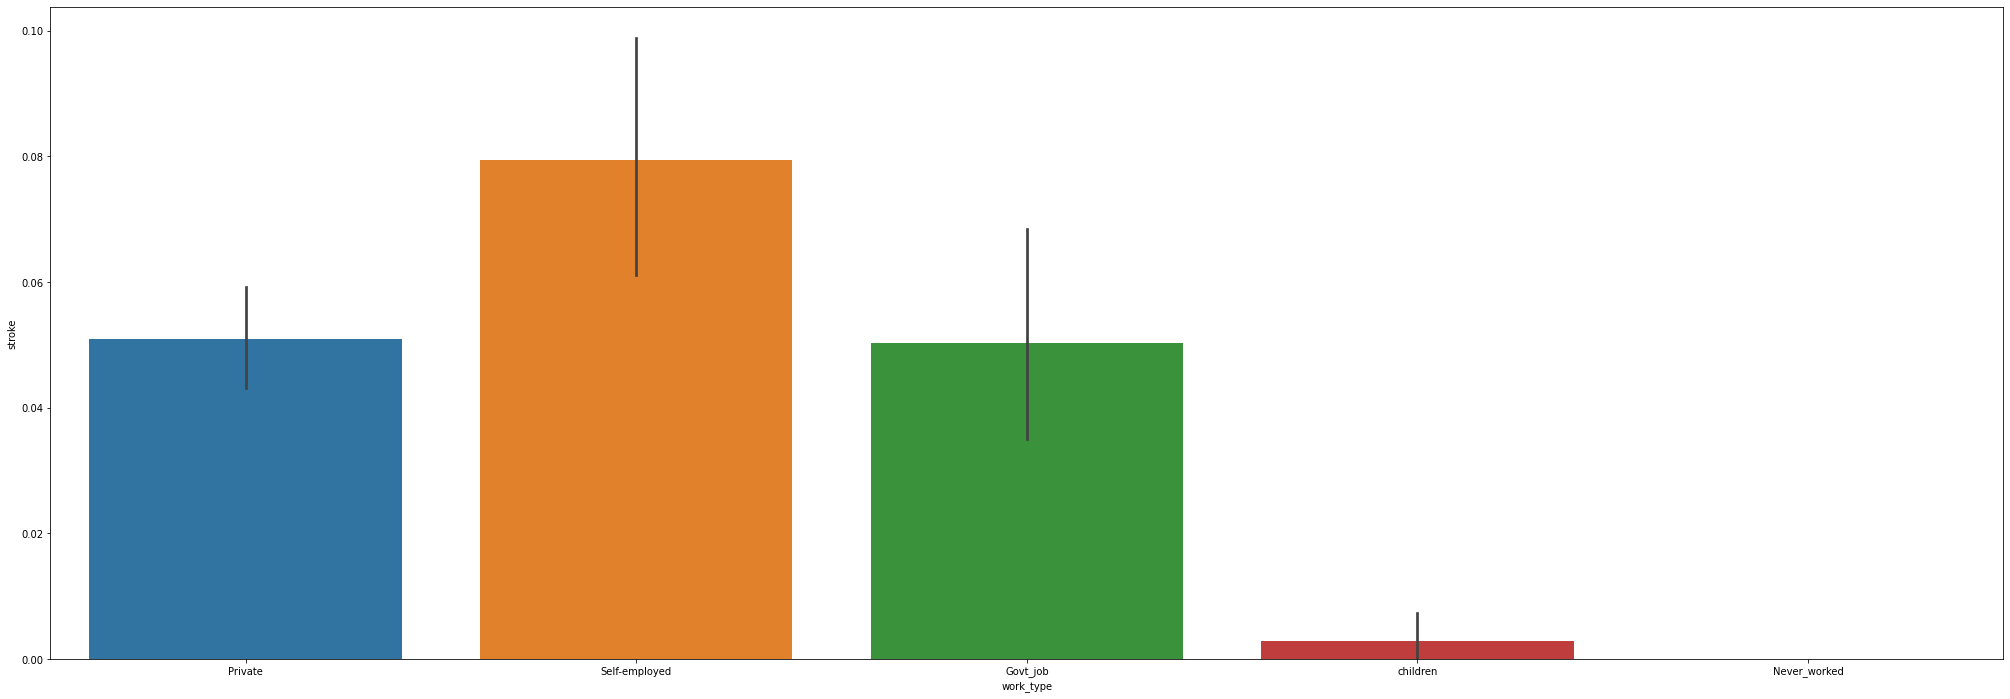

In [ ]:
# Plot relationship between work type and stroke
plt.figure(figsize=(35, 12))
sns.barplot(data=stroke_df, x='work_type', y='stroke')

Text(0.5, 6.79999999999999, 'Average glucose level')

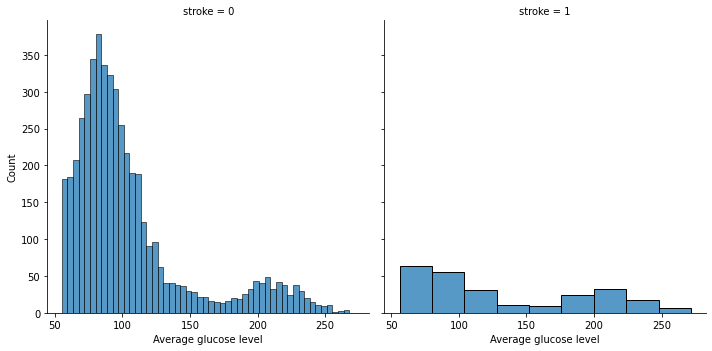

In [ ]:
# Histogram of average glucose level in view of stroke
facetgrid = sns.FacetGrid(stroke_df, col = 'stroke', height=5)
facetgrid.map(sns.histplot, 'avg_glucose_level')
facetgrid.axes[0, 0].set_xlabel('Average glucose level')
facetgrid.axes[0, 1].set_xlabel('Average glucose level')

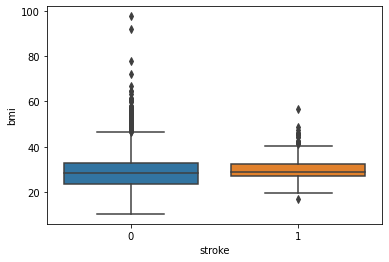

In [ ]:
# Boxplot of bmi in view of stroke
sns.boxplot(x=stroke_df['stroke'], y=stroke_df['bmi'])

In [ ]:
stroke_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0


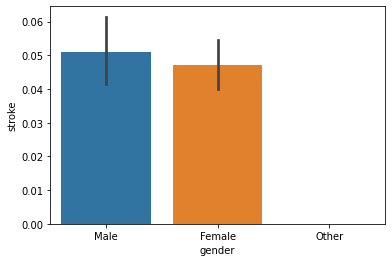

In [ ]:
sns.barplot(data=stroke_df, x='gender', y='stroke')

In [ ]:
np.unique(stroke_df['smoking_status'].values)

array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
      dtype=object)

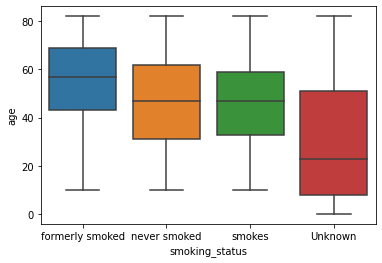

In [ ]:
# Relationship between smoking and stroke
sns.boxplot(x=stroke_df['smoking_status'], y=stroke_df['age'])

In [ ]:
Counter(stroke_df['smoking_status'])

Counter({'Unknown': 1544,
         'formerly smoked': 885,
         'never smoked': 1892,
         'smokes': 789})

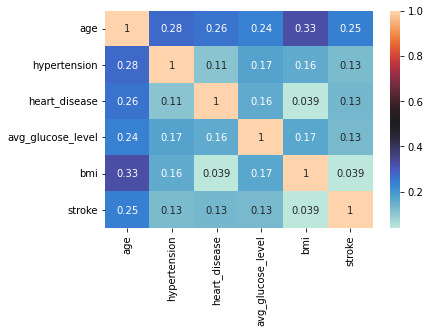

In [ ]:
sns.heatmap(data=stroke_df.corr(), annot=True, cmap='icefire')

# Investigate categorical data and convert into numerical data

In [ ]:
# Select only object datatypes
stroke_df_obj = stroke_df.select_dtypes(include='object')
stroke_df_obj

,gender,ever_married,work_type,Residence_type,smoking_status
id,,,,,
9046,Male,Yes,Private,Urban,formerly smoked
51676,Female,Yes,Self-employed,Rural,never smoked
31112,Male,Yes,Private,Rural,never smoked
60182,Female,Yes,Private,Urban,smokes
1665,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
18234,Female,Yes,Private,Urban,never smoked
44873,Female,Yes,Self-employed,Urban,never smoked
19723,Female,Yes,Self-employed,Rural,never smoked


In [ ]:
stroke_df['gender'].value_counts().values.sum()

5110

In [ ]:
# Gender - nominal -> dummy variable 
Counter(stroke_df['gender'])

Counter({'Female': 2994, 'Male': 2115, 'Other': 1})

([<matplotlib.patches.Wedge at 0x7f1a8e935550>,
 [Text(-0.2932923170393164, 1.0601790493901062, 'male'),
  Text(0.2926404138262685, -1.0603591788613849, 'female'),
  Text(1.099999792043413, -0.0006763907511957427, 'other')],
 [Text(-0.15997762747599073, 0.5782794814855124, '58.59% (2994)'),
  Text(0.15962204390523732, -0.5783777339243917, '41.39% (2115)'),
  Text(0.5999998865691343, -0.00036894040974313233, '0.02% (1)')])

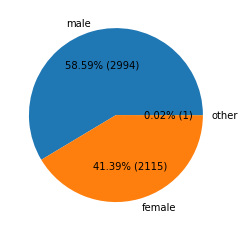

In [ ]:

plt.pie(stroke_df['gender'].value_counts().values, labels = ['male', 'female', 'other'], autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*5110))

In [ ]:
# Ever married - nominal
Counter(stroke_df['ever_married'])

Counter({'No': 1757, 'Yes': 3353})

([<matplotlib.patches.Wedge at 0x7f1a8e89b090>,
 [Text(-0.5182755321100738, 0.9702527881001013, 'yes'),
  Text(0.5182756229516939, -0.9702527395756395, 'no')],
 [Text(-0.28269574478731296, 0.5292287935091461, '65.62% (3353)'),
  Text(0.28269579433728753, -0.5292287670412579, '34.38% (1757)')])

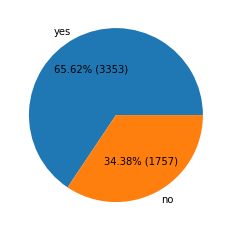

In [ ]:
plt.pie(stroke_df['ever_married'].value_counts().values, labels = ['yes', 'no'], autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*5110))

In [ ]:
# Work type - ordinal (never worked, children) (govt_job, private, self_employed)
Counter(stroke_df['work_type'])

Counter({'Govt_job': 657,
         'Never_worked': 22,
         'Private': 2925,
         'Self-employed': 819,
         'children': 687})

([<matplotlib.patches.Wedge at 0x7f1a8e8622d0>,
 [Text(-0.24806852328675594, 1.0716631969767034, 'private'),
  Text(-0.6322566579485418, -0.9001397216431128, 'self-employed'),
  Text(0.33927557636489136, -1.0463709109499704, 'children'),
  Text(0.9994171384323685, -0.4595273478343333, 'governmant job'),
  Text(1.0998993881382721, -0.01487736445256784, 'never worked')],
 [Text(-0.13531010361095777, 0.5845435619872926, '57.24% (2925)'),
  Text(-0.34486726797193185, -0.49098530271442514, '16.03% (819)'),
  Text(0.18505940528994072, -0.5707477696090747, '13.44% (687)'),
  Text(0.54513662096311, -0.25065128063690906, '12.86% (657)'),
  Text(0.5999451208026939, -0.008114926065037002, '0.43% (22)')])

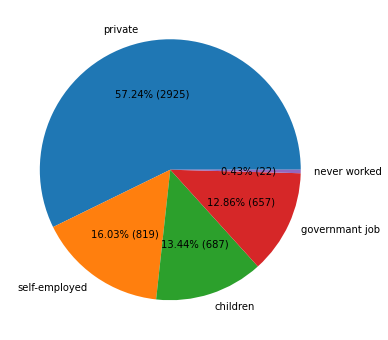

In [ ]:
work_labels = ['private', 'self-employed', 'children', 'governmant job', 'never worked']
plt.figure(figsize=(6, 6))
plt.pie(stroke_df['work_type'].value_counts().values, labels = work_labels, autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*5110))

In [ ]:
# Residence type - nominal
Counter(stroke_df['Residence_type'])

Counter({'Rural': 2514, 'Urban': 2596})

([<matplotlib.patches.Wedge at 0x7f1a8e838f90>,
 [Text(-0.02772429096401782, 1.0996505643569428, 'urban'),
  Text(0.027724393920734242, -1.0996505617612025, 'rural')],
 [Text(-0.0151223405258279, 0.5998093987401505, '50.80% (2596)'),
  Text(0.015122396684036858, -0.5998093973242922, '49.20% (2514)')])

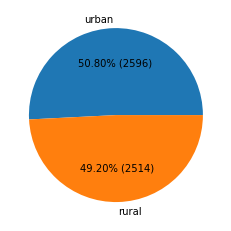

In [ ]:
plt.pie(stroke_df['Residence_type'].value_counts().values, labels = ['urban', 'rural'], autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*5110))

In [ ]:
# Smoking status - ordinal (unknown, never smoked) formerly smoked, smokes
Counter(stroke_df['smoking_status'])

Counter({'Unknown': 1544,
         'formerly smoked': 885,
         'never smoked': 1892,
         'smokes': 789})

([<matplotlib.patches.Wedge at 0x7f1a8e8e7a10>,
 [Text(0.4360557107141461, 1.0098789121244096, 'never smoked'),
  Text(-1.0901353192802539, -0.1469863451404224, 'unknown'),
  Text(0.0621837781835764, -1.0982409470288457, 'formerly smoked'),
  Text(0.9731055953448219, -0.512899113187574, 'smokes')],
 [Text(0.2378485694804433, 0.5508430429769506, '37.03% (1892)'),
  Text(-0.5946192650619565, -0.08017437007659402, '30.22% (1544)'),
  Text(0.03391842446376894, -0.5990405165611885, '17.32% (885)'),
  Text(0.5307848701880846, -0.2797631526477676, '15.44% (789)')])

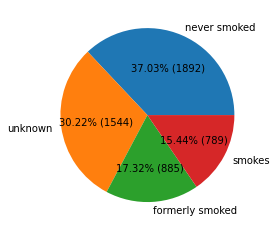

In [ ]:
plt.pie(stroke_df['smoking_status'].value_counts().values, labels = ['never smoked', 'unknown', 'formerly smoked', 'smokes'], autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*5110))

In [ ]:
# Heart disease - alredy encoded in dataset
Counter(stroke_df['heart_disease'])

Counter({0: 4834, 1: 276})

([<matplotlib.patches.Wedge at 0x7f1a8e7f2cd0>,
 [Text(-1.0842021913429936, 0.18575685259782707, 'no'),
  Text(1.0842021804731095, -0.1857569160417862, 'yes')],
 [Text(-0.5913830134598146, 0.10132191959881474, '94.60% (4834)'),
  Text(0.5913830075307869, -0.10132195420461064, '5.40% (276)')])

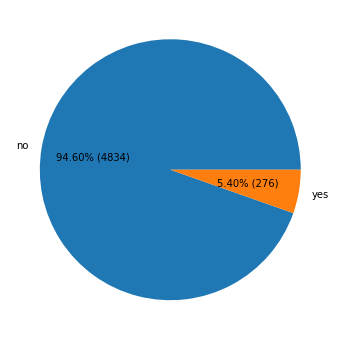

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(stroke_df['heart_disease'].value_counts().values, labels = ['no', 'yes'], autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*5110))

In [ ]:
# Hypertension - alredy encoded in dataset
Counter(stroke_df['hypertension'])

Counter({0: 4612, 1: 498})

([<matplotlib.patches.Wedge at 0x7f1a8e723a10>,
 [Text(-1.0488454518125865, 0.3315467059285184, 'no'),
  Text(1.0488454440521755, -0.3315467304785183, 'yes')],
 [Text(-0.5720975191705017, 0.18084365777919187, '90.25% (4612)'),
  Text(0.5720975149375501, -0.1808436711701009, '9.75% (498)')])

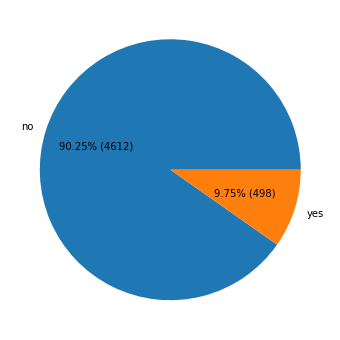

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(stroke_df['hypertension'].value_counts().values, labels = ['no', 'yes'], autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*5110))

In [ ]:
# Stroke - alredy encoded in dataset
Counter(stroke_df['stroke'])

Counter({0: 4861, 1: 249})

([<matplotlib.patches.Wedge at 0x7f1a8e6f76d0>,
 [Text(-1.0871361453364168, 0.16773491438301516, 'no'),
  Text(1.087136143373357, -0.1677349271061446, 'yes')],
 [Text(-0.5929833520016818, 0.09149177148164463, '95.13% (4861)'),
  Text(0.592983350930922, -0.0914917784215334, '4.87% (249)')])

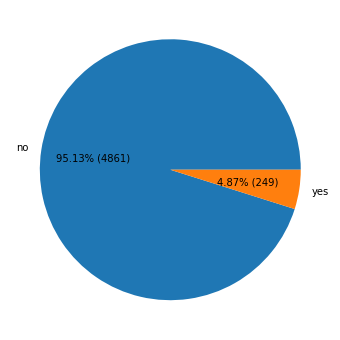

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(stroke_df['stroke'].value_counts().values, labels = ['no', 'yes'], autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*5110))

In [ ]:
# Encode ordinal categorical features

# Convert them into category data type 
stroke_df_obj['ever_married'] = stroke_df_obj['ever_married'].astype('category')
stroke_df_obj['work_type'] = stroke_df_obj['work_type'].astype('category')
stroke_df_obj['Residence_type'] = stroke_df_obj['Residence_type'].astype('category')
stroke_df_obj['smoking_status'] = stroke_df_obj['smoking_status'].astype('category')

stroke_df_obj.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

gender              object
ever_married      category
work_type         category
Residence_type    category
smoking_status    category
dtype: object

In [ ]:
# Encode the ever married and work type

stroke_df_obj['ever_married_enc'] = stroke_df_obj['ever_married'].cat.codes
stroke_df_obj['residence_type_enc'] = stroke_df_obj['Residence_type'].cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
stroke_df_obj

,gender,ever_married,work_type,Residence_type,smoking_status,ever_married_enc,residence_type_enc
id,,,,,,,
9046,Male,Yes,Private,Urban,formerly smoked,1,1
51676,Female,Yes,Self-employed,Rural,never smoked,1,0
31112,Male,Yes,Private,Rural,never smoked,1,0
60182,Female,Yes,Private,Urban,smokes,1,1
1665,Female,Yes,Self-employed,Rural,never smoked,1,0
...,...,...,...,...,...,...,...
18234,Female,Yes,Private,Urban,never smoked,1,1
44873,Female,Yes,Self-employed,Urban,never smoked,1,1
19723,Female,Yes,Self-employed,Rural,never smoked,1,0


In [ ]:
# Encode work_type and smoking_status

coding_wt_ss_dict = {"work_type" : {'children' : 0,
                                    'Never_worked' : 1,
                                    'Self-employed' : 2,
                                    'Govt_job' : 3,
                                    'Private' : 4},
                     "smoking_status" : {'Unknown' : 0,
                                         'never smoked' : 1,
                                         'formerly smoked' : 2,
                                         'smokes' : 3}}

stroke_df_obj = stroke_df_obj.replace(coding_wt_ss_dict)
stroke_df_obj



,gender,ever_married,work_type,Residence_type,smoking_status,ever_married_enc,residence_type_enc
id,,,,,,,
9046,Male,Yes,4,Urban,2,1,1
51676,Female,Yes,2,Rural,1,1,0
31112,Male,Yes,4,Rural,1,1,0
60182,Female,Yes,4,Urban,3,1,1
1665,Female,Yes,2,Rural,1,1,0
...,...,...,...,...,...,...,...
18234,Female,Yes,4,Urban,1,1,1
44873,Female,Yes,2,Urban,1,1,1
19723,Female,Yes,2,Rural,1,1,0


In [ ]:
# Copy stroke df
stroke_df_cp = copy.deepcopy(stroke_df)

In [ ]:
# Encode nominal categories
stroke_df_cp = pd.get_dummies(stroke_df_cp, columns=['gender'], prefix='gender')
stroke_df_cp

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male,gender_Other
id,,,,,,,,,,,,,
9046,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,0,1,0
51676,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,1,0,0
31112,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,0,1,0
60182,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,1,0,0
1665,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0,1,0,0
44873,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0,1,0,0
19723,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0,1,0,0


In [ ]:
# Replace noncoded categorical values with encoded ones
stroke_df_cp['ever_married'] = stroke_df_obj['ever_married_enc']
stroke_df_cp['work_type'] = stroke_df_obj['work_type']
stroke_df_cp['Residence_type'] = stroke_df_obj['residence_type_enc']
stroke_df_cp['smoking_status'] = stroke_df_obj['smoking_status']

stroke_df_cp

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male,gender_Other
id,,,,,,,,,,,,,
9046,67.0,0,1,1,4,1,228.69,36.600000,2,1,0,1,0
51676,61.0,0,0,1,2,0,202.21,28.893237,1,1,1,0,0
31112,80.0,0,1,1,4,0,105.92,32.500000,1,1,0,1,0
60182,49.0,0,0,1,4,1,171.23,34.400000,3,1,1,0,0
1665,79.0,1,0,1,2,0,174.12,24.000000,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,80.0,1,0,1,4,1,83.75,28.893237,1,0,1,0,0
44873,81.0,0,0,1,2,1,125.20,40.000000,1,0,1,0,0
19723,35.0,0,0,1,2,0,82.99,30.600000,1,0,1,0,0


# Normalization and train-test split

In [ ]:
# Extract target values
y = stroke_df_cp.pop('stroke')
y[:10]

id
9046     1
51676    1
31112    1
60182    1
1665     1
56669    1
53882    1
10434    1
27419    1
60491    1
Name: stroke, dtype: int64

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(stroke_df_cp, y, train_size=0.7, shuffle=True, random_state=1)

print('X train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('y test shape: {}'.format(y_test.shape))

X train shape: (3577, 12)
y_train shape: (3577,)
X test shape: (1533, 12)
y test shape: (1533,)


In [ ]:
# Normalize numerical data in test set with training set mean and standard deviation
X_test['age'] = (X_test['age'] - X_train['age'].mean())/X_train['age'].std()
X_test['avg_glucose_level'] = (X_test['avg_glucose_level'] - X_train['avg_glucose_level'].mean())/X_train['avg_glucose_level'].std()
X_test['bmi'] = (X_test['bmi'] - X_train['bmi'].mean())/X_train['bmi'].std()
X_test

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,gender_Other
id,,,,,,,,,,,,
49833,-0.058246,0,0,1,3,0,0.159719,1.074097,2,1,0,0
20375,1.542563,0,0,1,4,1,-0.602329,0.145013,2,1,0,0
39834,-0.680782,0,0,0,4,1,-0.712605,-0.470014,3,0,1,0
42550,1.675963,0,0,1,2,0,3.089287,-1.032699,1,1,0,0
19907,0.386423,0,0,1,4,0,-0.190221,-0.129786,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11792,1.186828,0,0,1,4,1,-0.334327,-0.012015,2,1,0,0
22485,0.564291,0,0,1,4,1,2.007614,1.911581,2,0,1,0
38354,0.831092,0,0,1,2,1,-0.305110,-1.228984,0,1,0,0


In [ ]:
# normalize numerical data in train set

X_train['age'] = (X_train['age'] - X_train['age'].mean())/X_train['age'].std()
X_train['avg_glucose_level'] = (X_train['avg_glucose_level'] - X_train['avg_glucose_level'].mean())/X_train['avg_glucose_level'].std()
X_train['bmi'] = (X_train['bmi'] - X_train['bmi'].mean())/X_train['bmi'].std()
X_train

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,gender_Other
id,,,,,,,,,,,,
68371,0.608758,0,0,1,4,1,0.638168,0.014156,0,0,1,0
22706,-1.886725,0,0,0,0,0,-0.386609,-1.765497,0,1,0,0
8175,-1.036518,0,0,0,4,1,-0.466131,-1.111213,1,0,1,0
66065,-1.347786,0,0,0,0,0,0.697261,-1.412184,0,0,1,0
61291,-0.680782,0,0,1,4,0,1.401095,-0.234472,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56855,0.119622,0,0,1,4,1,0.704290,0.040328,1,0,1,0
72451,0.075155,0,0,1,4,0,-0.922174,0.393641,0,1,0,0
9262,-0.547382,0,0,1,4,0,-0.646923,0.864726,1,1,0,0


In [ ]:
X_train

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,gender_Other
id,,,,,,,,,,,,
68371,0.608758,0,0,1,4,1,0.638168,0.014156,0,0,1,0
22706,-1.886725,0,0,0,0,0,-0.386609,-1.765497,0,1,0,0
8175,-1.036518,0,0,0,4,1,-0.466131,-1.111213,1,0,1,0
66065,-1.347786,0,0,0,0,0,0.697261,-1.412184,0,0,1,0
61291,-0.680782,0,0,1,4,0,1.401095,-0.234472,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
56855,0.119622,0,0,1,4,1,0.704290,0.040328,1,0,1,0
72451,0.075155,0,0,1,4,0,-0.922174,0.393641,0,1,0,0
9262,-0.547382,0,0,1,4,0,-0.646923,0.864726,1,1,0,0


In [ ]:
# Count stroke and not stroke samples in train set
Counter(y_train)

Counter({0: 3411, 1: 166})

In [ ]:
# Count stroke and not stroke samples in test set
Counter(y_test)

Counter({0: 1450, 1: 83})

In [ ]:
# Concatinate test and train sets, because the decision tree and randomforest requires them
stroke_df_norm = pd.concat([X_train, X_test])
stroke_df_norm

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,gender_Other
id,,,,,,,,,,,,
68371,0.608758,0,0,1,4,1,0.638168,0.014156,0,0,1,0
22706,-1.886725,0,0,0,0,0,-0.386609,-1.765497,0,1,0,0
8175,-1.036518,0,0,0,4,1,-0.466131,-1.111213,1,0,1,0
66065,-1.347786,0,0,0,0,0,0.697261,-1.412184,0,0,1,0
61291,-0.680782,0,0,1,4,0,1.401095,-0.234472,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11792,1.186828,0,0,1,4,1,-0.334327,-0.012015,2,1,0,0
22485,0.564291,0,0,1,4,1,2.007614,1.911581,2,0,1,0
38354,0.831092,0,0,1,2,1,-0.305110,-1.228984,0,1,0,0


In [ ]:
# Concatinate test and train labels, because the decision tree and randomforest requires them
y_all = pd.concat([y_train, y_test])
y_all

id
68371    0
22706    0
8175     0
66065    0
61291    0
        ..
11792    0
22485    0
38354    0
55138    0
22155    0
Name: stroke, Length: 5110, dtype: int64

In [ ]:
Counter(y)

Counter({0: 4861, 1: 249})

There are very few patients with stroke can occur as a problem in prediction. 

In [ ]:
# Solve imbalanced label numbers with oversampling by using SMOTE
smote = SMOTE()

x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Counter(y_train_smote)

Counter({0: 3411, 1: 3411})

In [ ]:
Counter(y_train)

Counter({0: 3411, 1: 166})

In [ ]:
# TESTING!!!!!!!
smote = SMOTE()

stroke_df_norm_smote, y_all_smote = smote.fit_resample(stroke_df_norm, y_all)

print('stroke_df norm shape: {}'.format(stroke_df_norm_smote.shape))

stroke_df norm shape: (9722, 12)


In [ ]:
Counter(y_all_smote)

Counter({0: 4861, 1: 4861})

In [ ]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(stroke_df_norm_smote, y_all_smote, train_size=0.7, shuffle=True, random_state=1)

print('X train shape: {}'.format(X_train_smote.shape))
print('y_train shape: {}'.format(y_train_smote.shape))
print('X test shape: {}'.format(X_test_smote.shape))
print('y test shape: {}'.format(y_test_smote.shape))

X train shape: (6805, 12)
y_train shape: (6805,)
X test shape: (2917, 12)
y test shape: (2917,)


In [ ]:
Counter(y_train_smote)

Counter({0: 3401, 1: 3404})

In [ ]:
Counter(y_test_smote)

Counter({0: 1460, 1: 1457})

In [ ]:
# Prepare logistic regression model
logreg_smote = LogisticRegression(random_state=0)
logreg = LogisticRegression(random_state=0)

# Fit the train set
logreg_smote.fit(X_train_smote, y_train_smote)
logreg.fit(X_train, y_train)
# Predict probabilities of test set
y_pred_prob_log_smote = logreg_smote.predict_proba(X_test_smote)
y_pred_prob_log = logreg.predict_proba(X_test_smote)
# Predict labels for confusion matrix
y_pred_log_smote = logreg_smote.predict(X_test_smote)
y_pred_log = logreg.predict(X_test_smote)

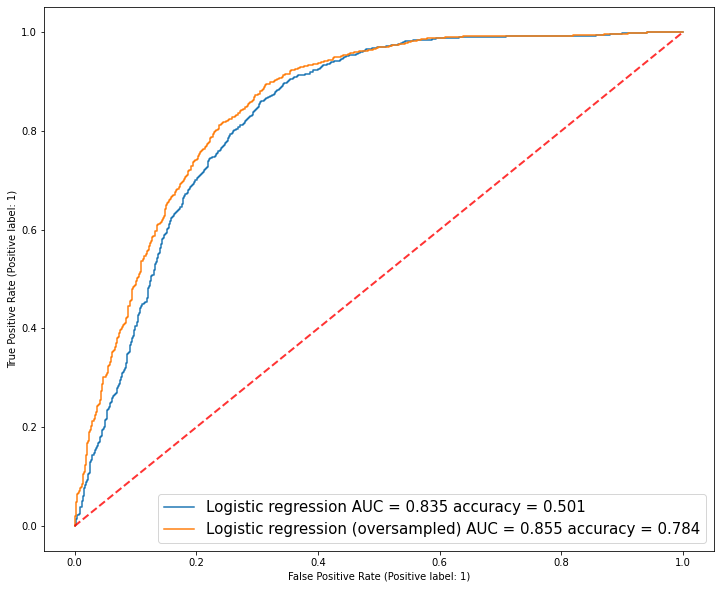

In [ ]:
# Plot ROC curves with AUC score and accuracy score
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(10)
RocCurveDisplay.from_predictions(y_test_smote, y_pred_prob_log[:, 1], ax=ax, label='Logistic regression AUC = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test_smote, y_pred_prob_log[:, 1]), np.round(accuracy_score(y_test_smote, y_pred_log), 3)))
RocCurveDisplay.from_predictions(y_test_smote, y_pred_prob_log_smote[:, 1], ax=ax, label='Logistic regression (oversampled) AUC = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test_smote, y_pred_prob_log_smote[:, 1]), accuracy_score(y_test_smote, y_pred_log_smote)))
plt.legend(prop={"size":15})
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)

# Baseline model

This is a classification problem, then the mode is used in baseline model build.

In [ ]:
# Prepare mode baseline model 
baseline_model = DummyClassifier(strategy='most_frequent')

# Predict probabilities of most frequent label as predicted probabilites for each sample in test set
baseline_model.fit(X_train, y_train)
y_pred_prob_base = baseline_model.predict_proba(X_test)
y_pred_base = baseline_model.predict(X_test)

# Calculate AUC score and accuracy
print('Baseline model AUC score: {}\tAccuracy score: {}'.format(roc_auc_score(y_test, y_pred_prob_base[:, 1]), accuracy_score(y_test, y_pred_base)))

Baseline model AUC score: 0.5	Accuracy score: 0.9458577951728636


In [ ]:
# Prepare mode baseline model with oversampled data
baseline_model_smote = DummyClassifier(strategy='most_frequent')

# Predict probabilities of most frequent label as predicted probabilites for each sample in test set
baseline_model_smote.fit(x_train_smote, y_train_smote)
y_pred_prob_base_smote = baseline_model_smote.predict_proba(X_test)
y_pred_base_smote = baseline_model_smote.predict(X_test)

# Calculate AUC score and accuracy
print('Baseline model with oversampled data AUC score: {}\tAccuracy score: {}'.format(roc_auc_score(y_test, y_pred_prob_base_smote[:, 1]), accuracy_score(y_test, y_pred_base_smote)))

Baseline model with oversampled data AUC score: 0.5	Accuracy score: 0.9458577951728636


# KNN classifier

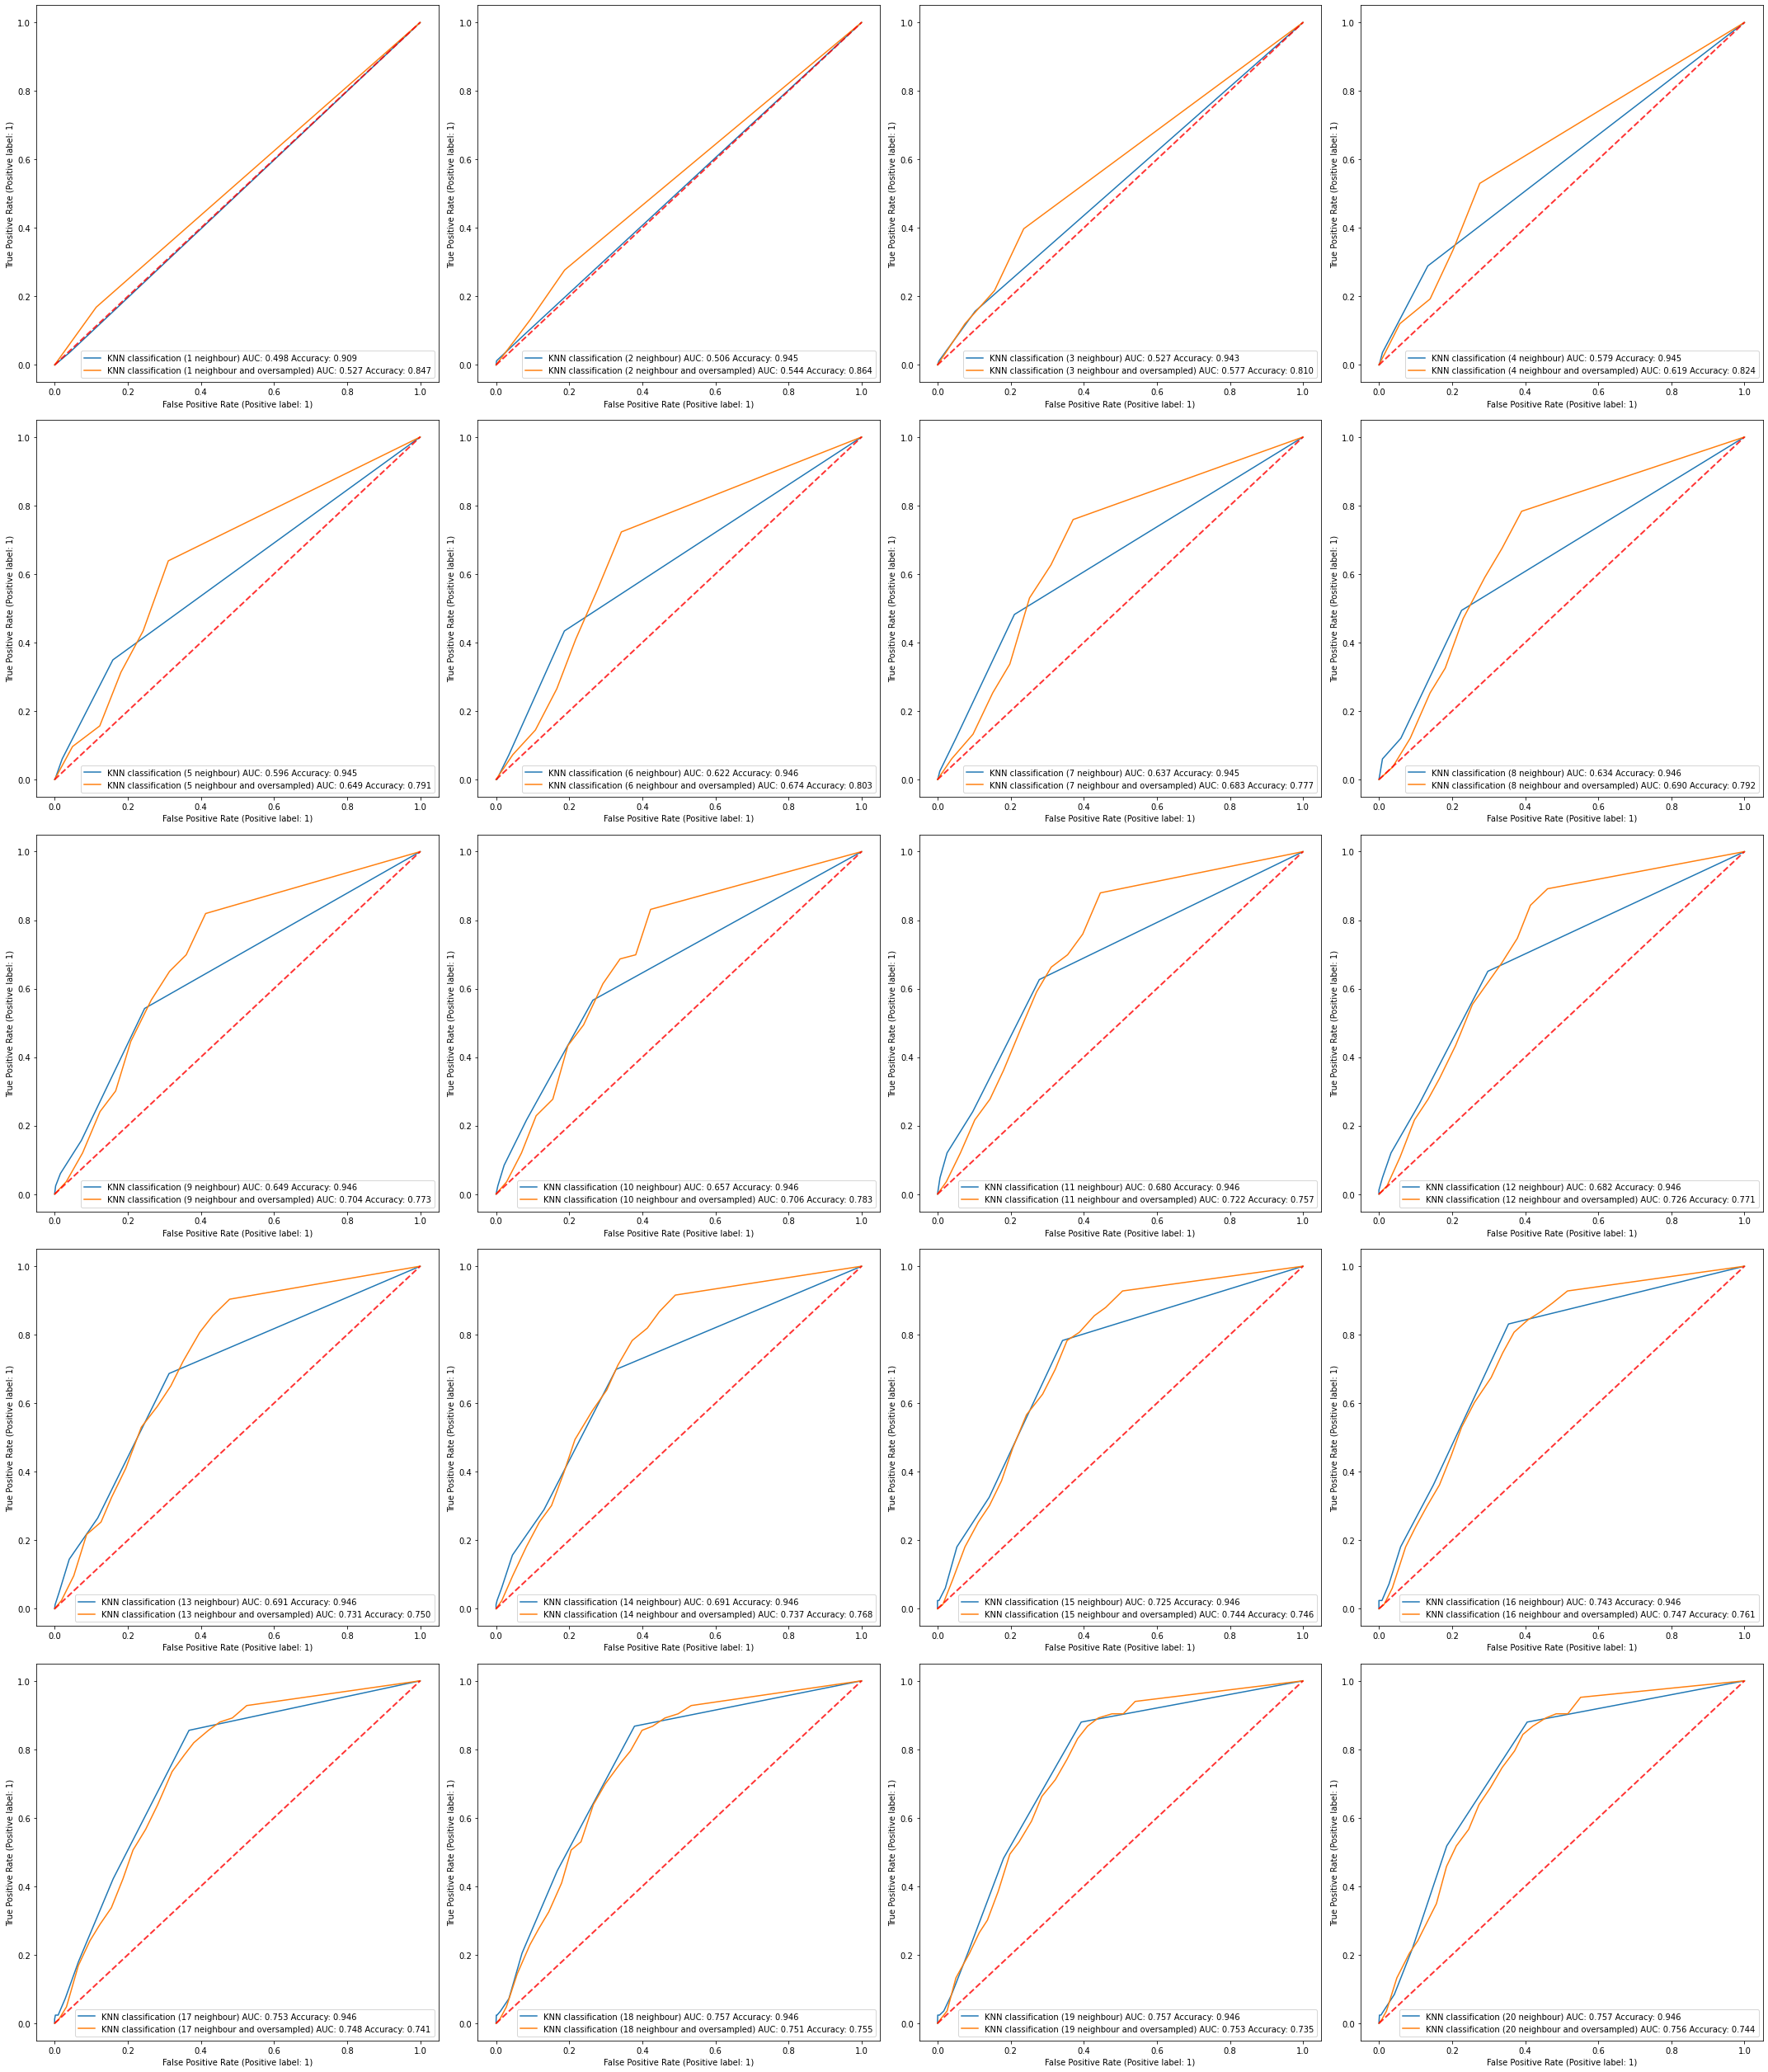

In [ ]:
# Perform KNN classification with increasing neighbour numbers


y_pred_knnclf_list = [[] for i in range(20)]
y_pred_prob_knnclf_list = [[] for i in range(20)]
y_pred_knnclf_smote_list = [[] for i in range(20)]
y_pred_prob_knnclf_smote_list = [[] for i in range(20)]

idx = 0
for neigh in range(1, 21):
  # set the model
  knn_classifier = KNeighborsClassifier(n_neighbors=neigh)
  knn_classifier_smote = KNeighborsClassifier(n_neighbors=neigh)
  # fit the train set
  knn_classifier.fit(X_train, y_train)
  knn_classifier_smote.fit(x_train_smote, y_train_smote)
  # predict
  y_pred_knnclf = knn_classifier.predict(X_test)
  y_pred_prob_knnclf = knn_classifier.predict_proba(X_test)
  y_pred_knnclf_smote = knn_classifier_smote.predict(X_test)
  y_pred_prob_knnclf_smote = knn_classifier_smote.predict_proba(X_test)
  
  # save the result
  y_pred_knnclf_list[idx].append(y_pred_knnclf)
  y_pred_prob_knnclf_list[idx].append(y_pred_prob_knnclf)
  y_pred_knnclf_smote_list[idx].append(y_pred_knnclf_smote)
  y_pred_prob_knnclf_smote_list[idx].append(y_pred_prob_knnclf_smote)
  
  idx += 1

# Calculate accuracy, AUC and plot ROC curves for each knn regression
subplot_pos = ['111', '112', '113', '114', '115', '121', '122', '123', '124', '125', '131', '132', '133', '134', '135', '141', '142', '143', '144', '145']

nrow, ncol = 0, 0
fig, ax = plt.subplots(5, 4, figsize=(30, 35))

for idx in range(len(y_pred_knnclf_list)):
  fig.tight_layout()
  RocCurveDisplay.from_predictions(y_test, y_pred_prob_knnclf_list[idx][0][:, 1], ax=ax[nrow][ncol], label='KNN classification ({} neighbour) AUC: {:.3f} Accuracy: {:.3f}'.format(idx+1, roc_auc_score(y_test, y_pred_prob_knnclf_list[idx][0][:, 1]), accuracy_score(y_test, np.round(y_pred_knnclf_list[idx][0]))))
  RocCurveDisplay.from_predictions(y_test, y_pred_prob_knnclf_smote_list[idx][0][:, 1], ax=ax[nrow][ncol], label='KNN classification ({} neighbour and oversampled) AUC: {:.3f} Accuracy: {:.3f}'.format(idx+1, roc_auc_score(y_test, y_pred_prob_knnclf_smote_list[idx][0][:, 1]), accuracy_score(y_test, np.round(y_pred_knnclf_smote_list[idx][0]))))
  ax[nrow][ncol].plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)
  if ncol == 3:
    ncol = 0
    nrow += 1
  else: ncol += 1





# Logistic regression

In [ ]:
# Prepare logistic regression model
logreg = LogisticRegression(random_state=0)
logreg_smote = LogisticRegression(random_state=0)

# Fit the train set
logreg.fit(X_train, y_train)
logreg_smote.fit(x_train_smote, y_train_smote)

# Predict probabilities of test set
y_pred_prob_log = logreg.predict_proba(X_test)
y_pred_prob_log_smote = logreg_smote.predict_proba(X_test)

# Predict labels for confusion matrix
y_pred_log = logreg.predict(X_test)
y_pred_log_smote = logreg_smote.predict(X_test)

In [ ]:
y_pred_prob_log

array([[0.98632963, 0.01367037],
       [0.82094907, 0.17905093],
       [0.99129121, 0.00870879],
       ...,
       [0.95340786, 0.04659214],
       [0.78376578, 0.21623422],
       [0.98566565, 0.01433435]])

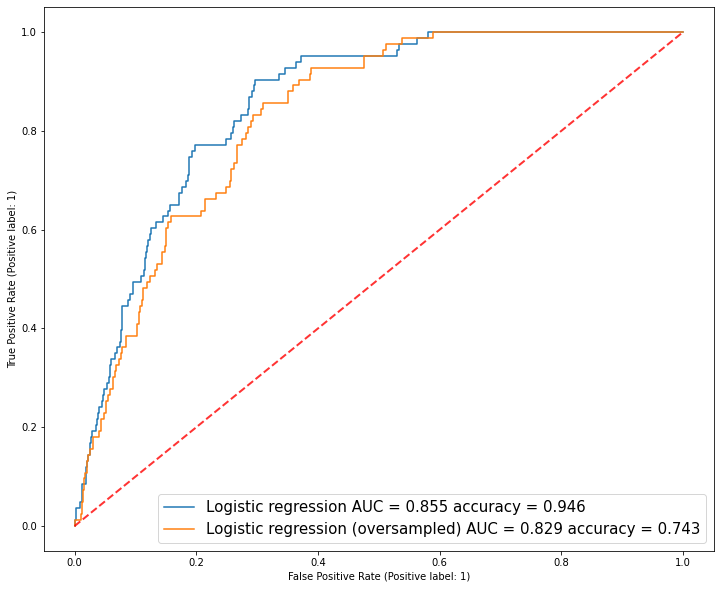

In [ ]:
# Plot ROC curves with AUC score and accuracy score
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(10)

RocCurveDisplay.from_predictions(y_test, y_pred_prob_log[:, 1], ax=ax, label='Logistic regression AUC = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_log[:, 1]), np.round(accuracy_score(y_test, y_pred_log), 3)))
RocCurveDisplay.from_predictions(y_test, y_pred_prob_log_smote[:, 1], ax=ax, label='Logistic regression (oversampled) AUC = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_log_smote[:, 1]), accuracy_score(y_test, y_pred_log_smote)))
plt.legend(prop={"size":15})
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)

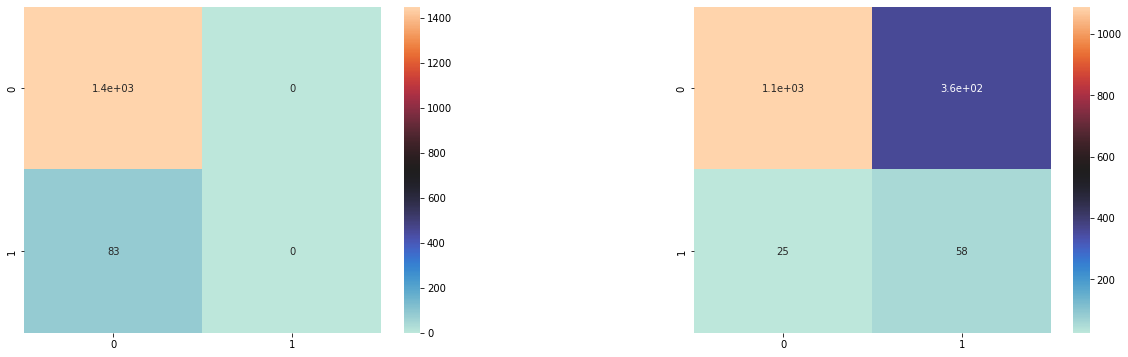

In [ ]:
# Confusion mattrix
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, cmap='icefire', ax=ax[0])
sns.heatmap(confusion_matrix(y_test, y_pred_log_smote), annot=True, cmap='icefire', ax=ax[1])
plt.subplots_adjust(wspace=0.5)

0

# Decision tree classifier and random forest

In [ ]:
# Resample whole dataset
smote = SMOTE()
stroke_df_norm_smote, y_all_smote = smote.fit_resample(stroke_df_norm, y_all)

In [ ]:
# Count stroke and not stroke samples in oversampled data
Counter(y_all_smote)  

Counter({0: 4861, 1: 4861})

In [ ]:
# Prepare decisiontree classifier
decisiontclf = DecisionTreeClassifier()
decisiontclf_smote = DecisionTreeClassifier()

# Fit data
decisiontclf.fit(stroke_df_norm, y_all)
decisiontclf_smote.fit(stroke_df_norm_smote, y_all_smote)

DecisionTreeClassifier()

[Text(1736.7749999999999, 747.4499999999999, 'age <= 1.076\ngini = 0.093\nsamples = 5110\nvalue = [4861, 249]'),
 Text(892.8, 611.55, 'age <= 0.453\ngini = 0.046\nsamples = 4254\nvalue = [4154, 100]'),
 Text(446.4, 475.65, 'age <= 0.053\ngini = 0.019\nsamples = 3244\nvalue = [3213, 31]'),
 Text(223.2, 339.74999999999994, 'age <= -0.258\ngini = 0.008\nsamples = 2533\nvalue = [2523, 10]'),
 Text(111.6, 203.8499999999999, 'avg_glucose_level <= -1.049\ngini = 0.003\nsamples = 2027\nvalue = [2024, 3]'),
 Text(55.8, 67.94999999999993, '\n  (...)  \n'),
 Text(167.39999999999998, 67.94999999999993, '\n  (...)  \n'),
 Text(334.79999999999995, 203.8499999999999, 'age <= -0.169\ngini = 0.027\nsamples = 506\nvalue = [499, 7]'),
 Text(279.0, 67.94999999999993, '\n  (...)  \n'),
 Text(390.59999999999997, 67.94999999999993, '\n  (...)  \n'),
 Text(669.5999999999999, 339.74999999999994, 'hypertension <= 0.5\ngini = 0.057\nsamples = 711\nvalue = [690, 21]'),
 Text(558.0, 203.8499999999999, 'smoking_sta

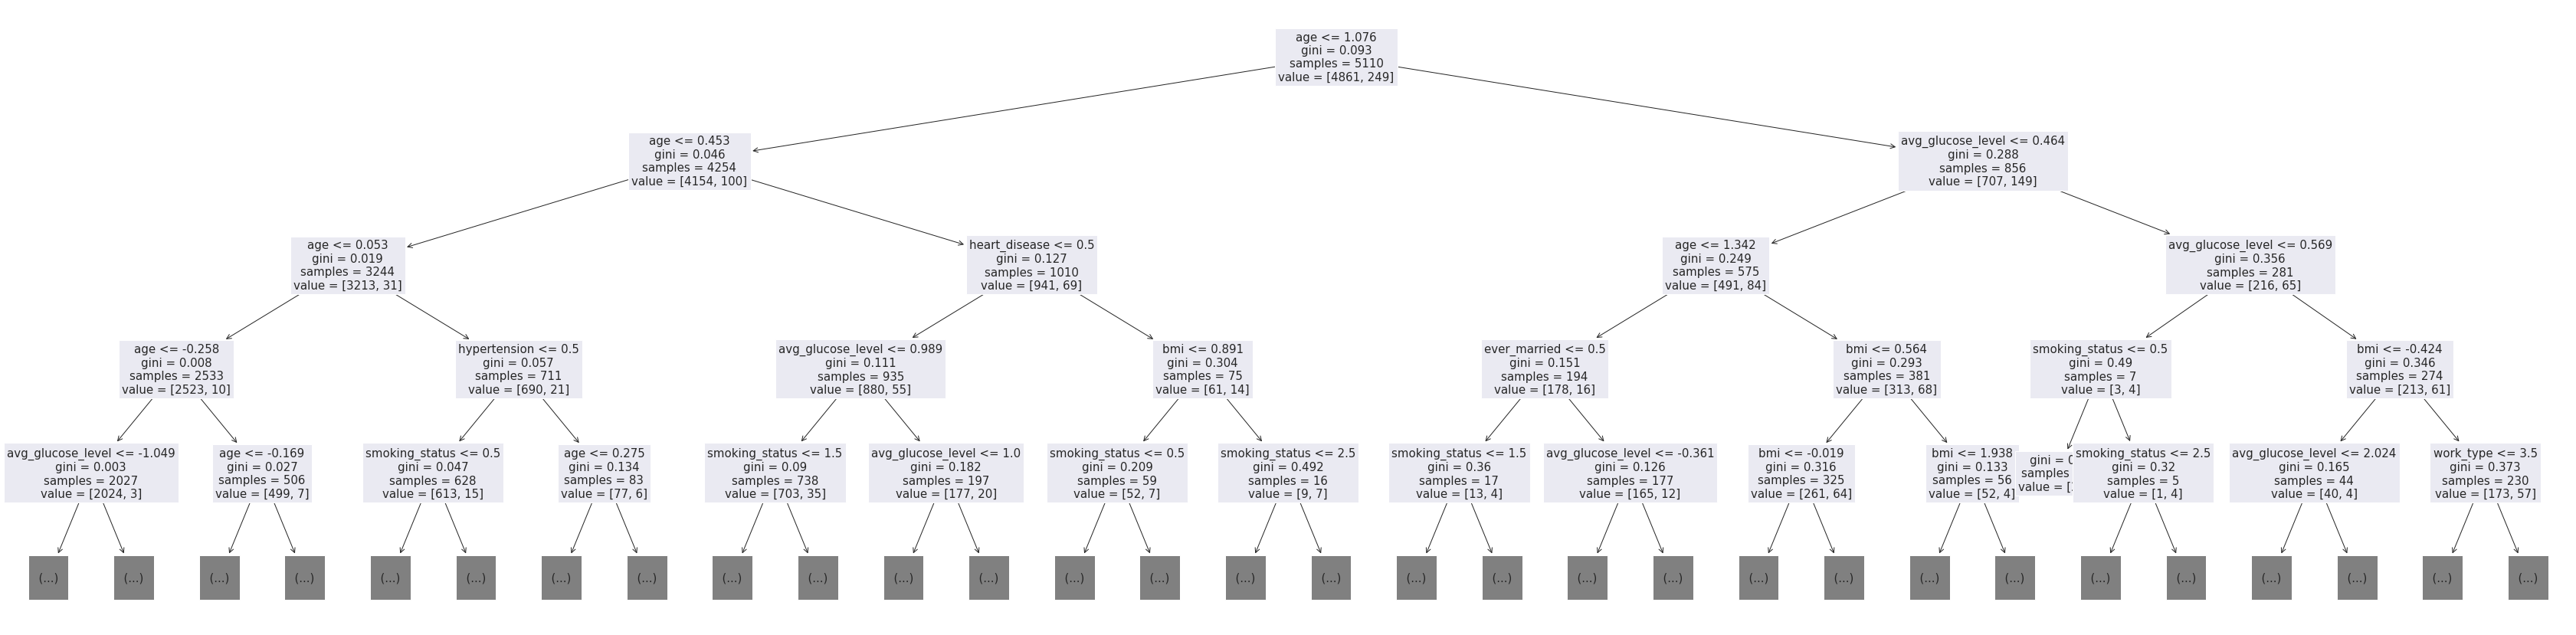

In [ ]:
# Plot decision tree of original data
plt.figure(figsize=(60, 15))
plot_tree(decisiontclf, feature_names=stroke_df_norm.columns, max_depth=4, fontsize=15)

[Text(1639.125, 747.4499999999999, 'age <= 0.52\ngini = 0.5\nsamples = 9722\nvalue = [4861, 4861]'),
 Text(823.05, 611.55, 'age <= 0.075\ngini = 0.247\nsamples = 3943\nvalue = [3375, 568]'),
 Text(446.4, 475.65, 'age <= -0.278\ngini = 0.102\nsamples = 2754\nvalue = [2605, 149]'),
 Text(223.2, 339.74999999999994, 'bmi <= -0.019\ngini = 0.039\nsamples = 2065\nvalue = [2024, 41]'),
 Text(111.6, 203.8499999999999, 'age <= -0.793\ngini = 0.011\nsamples = 1431\nvalue = [1423, 8]'),
 Text(55.8, 67.94999999999993, '\n  (...)  \n'),
 Text(167.39999999999998, 67.94999999999993, '\n  (...)  \n'),
 Text(334.79999999999995, 203.8499999999999, 'bmi <= 0.275\ngini = 0.099\nsamples = 634\nvalue = [601, 33]'),
 Text(279.0, 67.94999999999993, '\n  (...)  \n'),
 Text(390.59999999999997, 67.94999999999993, '\n  (...)  \n'),
 Text(669.5999999999999, 339.74999999999994, 'bmi <= 0.187\ngini = 0.264\nsamples = 689\nvalue = [581, 108]'),
 Text(558.0, 203.8499999999999, 'bmi <= -0.061\ngini = 0.361\nsamples = 3

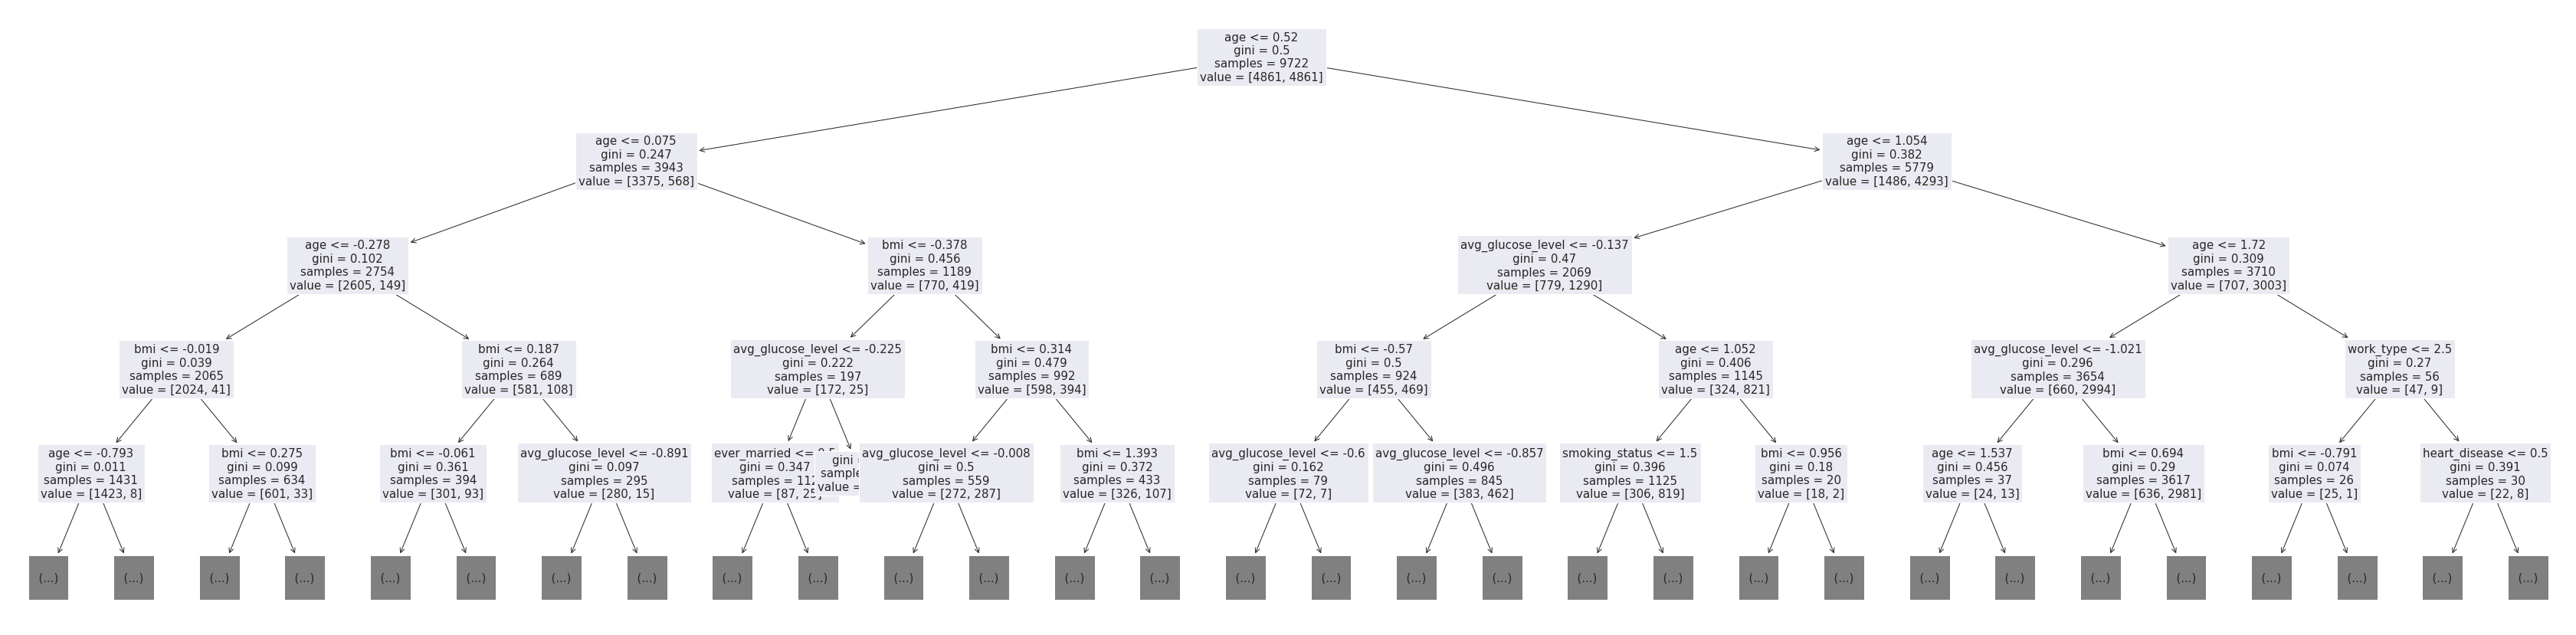

In [ ]:
# Plot decision tree of oversampled data
plt.figure(figsize=(60, 15))
plot_tree(decisiontclf_smote, feature_names=stroke_df_norm_smote.columns, max_depth=4, fontsize=15)

In [ ]:
# Randomforest classifier
randomfclf = RandomForestClassifier(random_state=57)
randomfclf_smote = RandomForestClassifier(random_state=57)

# Fit data
randomfclf.fit(stroke_df_norm, y_all)
randomfclf_smote.fit(stroke_df_norm_smote, y_all_smote)

RandomForestClassifier(random_state=57)

In [ ]:
# Find the first 10 important features of original and oversampled data based on Random Forest Classifier and Decision tree classifier

feature_imp_dtclf = pd.Series(data=decisiontclf.feature_importances_, index=stroke_df_norm.columns).sort_values(ascending=False)
feature_imp_dtclf_smote = pd.Series(data=decisiontclf_smote.feature_importances_, index=stroke_df_norm_smote.columns).sort_values(ascending=False)

feature_imp_rfclf = pd.Series(data=randomfclf.feature_importances_, index=stroke_df_norm.columns).sort_values(ascending=False)
feature_imp_rfclf_smote = pd.Series(data=randomfclf_smote.feature_importances_, index=stroke_df_norm_smote.columns).sort_values(ascending=False)

print('Decision tree classifier (original data)\n\n{}\n\nDecision tree classifier (oversampled data)\n\n{}\n\nRandom forest classifier (original data)\n\n{}\n\nRandom forest classifier (oversampled data)\n\n{}'.format(feature_imp_dtclf, feature_imp_dtclf_smote, feature_imp_rfclf, feature_imp_rfclf_smote))

Decision tree classifier (original data)

avg_glucose_level    0.268390
bmi                  0.248281
age                  0.193848
smoking_status       0.100960
gender_Male          0.039204
ever_married         0.030537
gender_Female        0.029641
Residence_type       0.027154
hypertension         0.026652
work_type            0.022733
heart_disease        0.012599
gender_Other         0.000000
dtype: float64

Decision tree classifier (oversampled data)

age                  0.581282
avg_glucose_level    0.155959
bmi                  0.115905
work_type            0.041695
smoking_status       0.033453
gender_Male          0.018374
ever_married         0.013071
Residence_type       0.012874
gender_Female        0.011384
hypertension         0.009231
heart_disease        0.006772
gender_Other         0.000000
dtype: float64

Random forest classifier (original data)

avg_glucose_level    2.823612e-01
bmi                  2.389427e-01
age                  2.344443e-01
smoking_status   

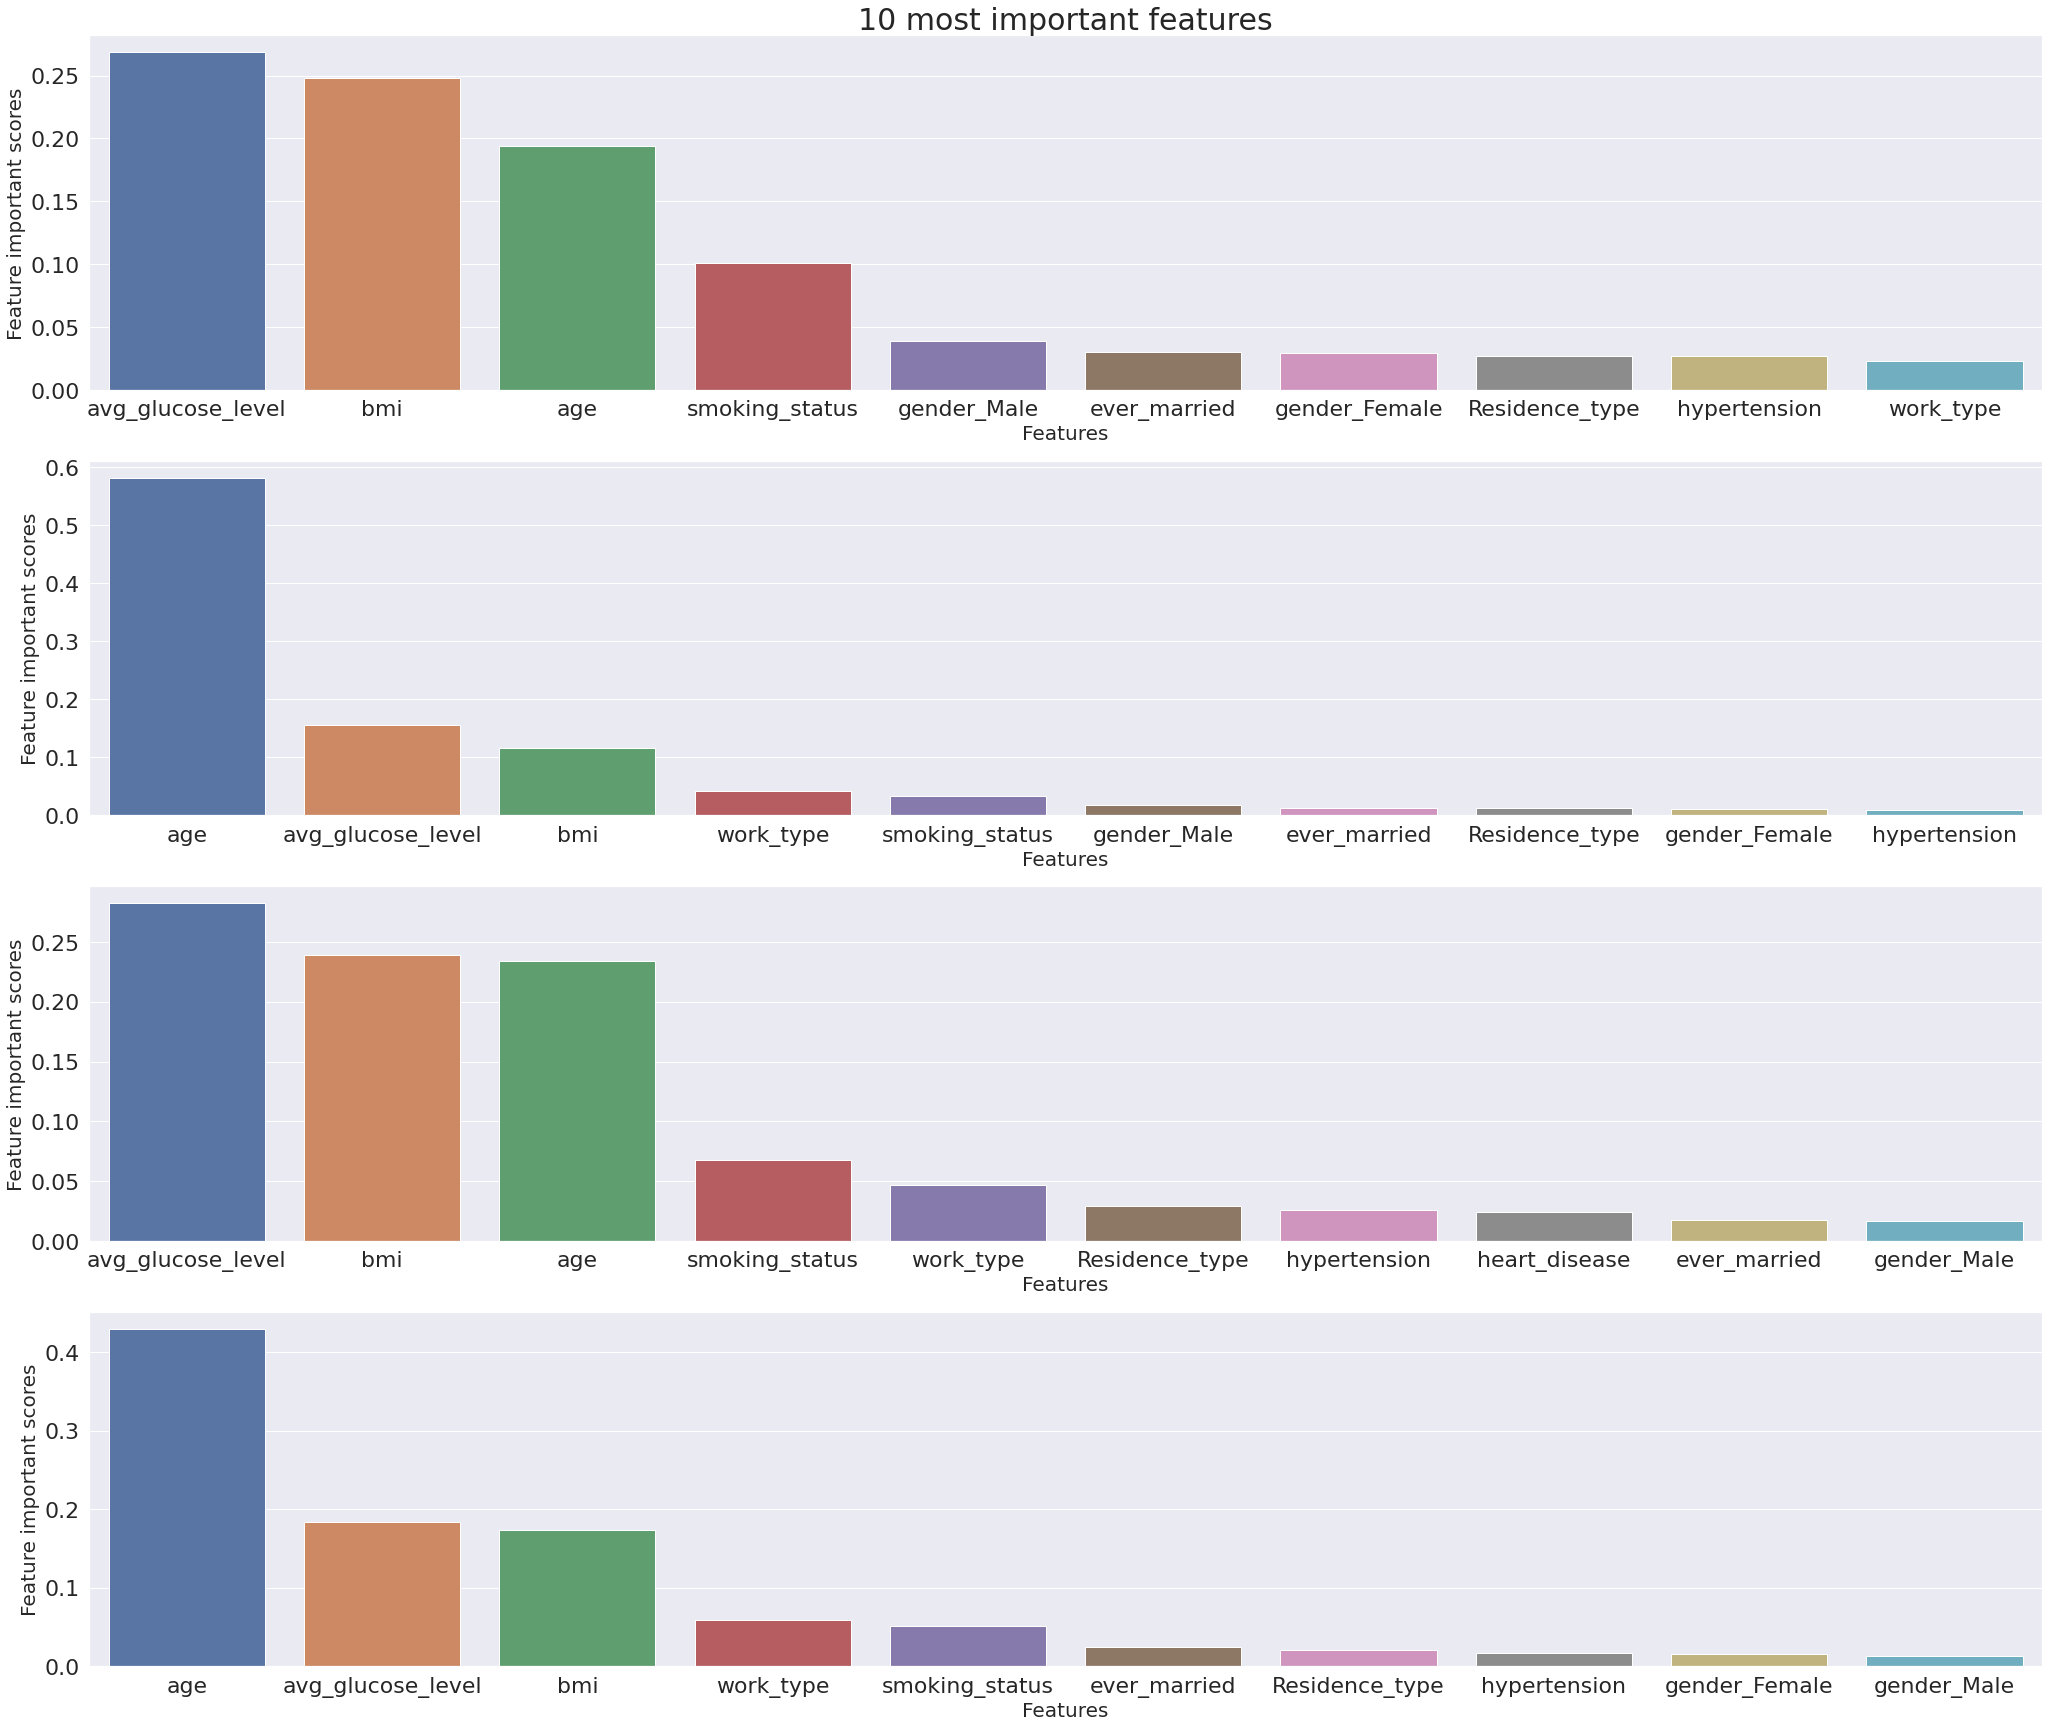

In [ ]:
# Plot importance of features for both original and oversampled data basen on decision tree and random forest classifier
sns.set(font_scale=2)
fig, (ax, ax2, ax3, ax4) = plt.subplots(4, figsize=(35, 30))
axes = [ax, ax2, ax3, ax4]
ax.set_title('10 most important features', fontsize=30)
for idx, imp_features in enumerate([feature_imp_dtclf, feature_imp_dtclf_smote, feature_imp_rfclf, feature_imp_rfclf_smote]):
  sns.barplot(x=imp_features.index[:10], y=imp_features[:10], ax=axes[idx])
  axes[idx].set_xlabel('Features', fontsize=20)
  axes[idx].set_ylabel('Feature important scores', fontsize=20)
   

In [ ]:
# Prediction with 5-fold cross validation
# Decision tree classifier
y_pred_prob_dtclf = cross_val_predict(estimator=decisiontclf, X=stroke_df_norm, y=y_all, cv=5, method='predict_proba')
y_pred_dtclf = cross_val_predict(estimator=decisiontclf, X=stroke_df_norm, y=y_all, cv=5, method='predict')
y_pred_prob_dtclf_smote = cross_val_predict(estimator=decisiontclf_smote, X=stroke_df_norm_smote, y=y_all_smote, cv=5, method='predict_proba')
y_pred_dtclf_smote = cross_val_predict(estimator=decisiontclf_smote, X=stroke_df_norm_smote, y=y_all_smote, cv=5, method='predict')

# Random forest classifier
y_pred_prob_rtclf = cross_val_predict(estimator=randomfclf, X=stroke_df_norm, y=y_all, cv=5, method='predict_proba')
y_pred_rtclf = cross_val_predict(estimator=randomfclf, X=stroke_df_norm, y=y_all, cv=5, method='predict')
y_pred_prob_rtclf_smote = cross_val_predict(estimator=randomfclf_smote, X=stroke_df_norm_smote, y=y_all_smote, cv=5, method='predict_proba')
y_pred_rtclf_smote = cross_val_predict(estimator=randomfclf_smote, X=stroke_df_norm_smote, y=y_all_smote, cv=5, method='predict')

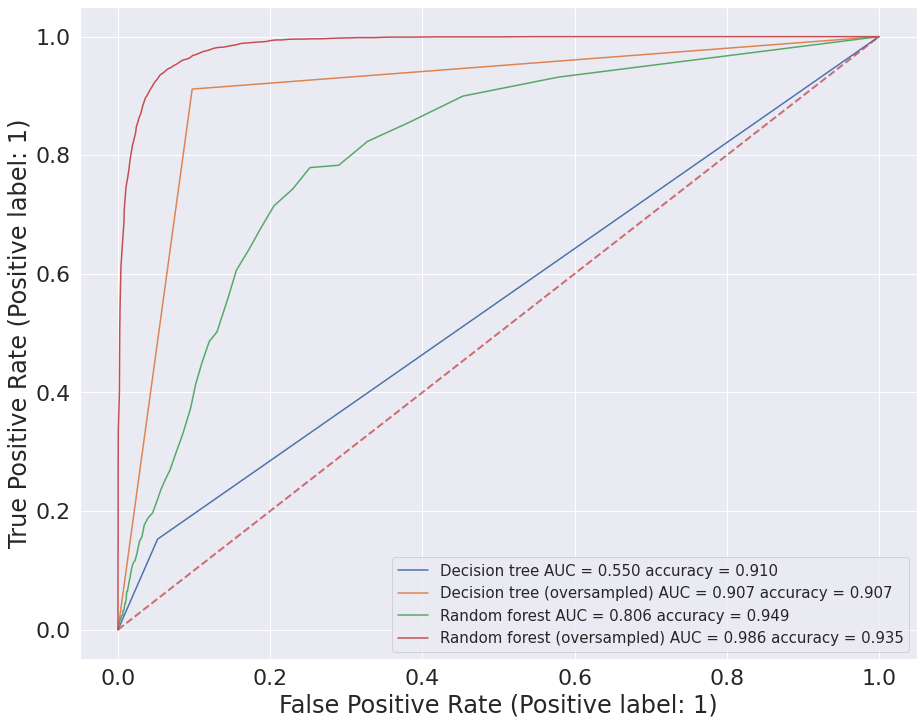

In [ ]:
# Plot ROC curves and AUC
fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(15)

# Decision tree 
RocCurveDisplay.from_predictions(y_all, y_pred_prob_dtclf[:, 1], ax=ax, label="Decision tree AUC = {:.3f} accuracy = {:.3f}".format(roc_auc_score(y_all, y_pred_prob_dtclf[:, 1]), accuracy_score(y_all, y_pred_dtclf)))
RocCurveDisplay.from_predictions(y_all_smote, y_pred_prob_dtclf_smote[:, 1], ax=ax, label="Decision tree (oversampled) AUC = {:.3f} accuracy = {:.3f}".format(roc_auc_score(y_all_smote, y_pred_prob_dtclf_smote[:, 1]), accuracy_score(y_all_smote, y_pred_dtclf_smote)))

# Random forest classifier
RocCurveDisplay.from_predictions(y_all, y_pred_prob_rtclf[:, 1], ax=ax, label="Random forest AUC = {:.3f} accuracy = {:.3f}".format(roc_auc_score(y_all, y_pred_prob_rtclf[:, 1]), accuracy_score(y_all, y_pred_rtclf)))
RocCurveDisplay.from_predictions(y_all_smote, y_pred_prob_rtclf_smote[:, 1], ax=ax, label="Random forest (oversampled) AUC = {:.3f} accuracy = {:.3f}".format(roc_auc_score(y_all_smote, y_pred_prob_rtclf_smote[:, 1]), accuracy_score(y_all_smote, y_pred_rtclf_smote)))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)
plt.legend(prop={"size":15})

Tree number: 1
Tree number: 2
Tree number: 3
Tree number: 4
Tree number: 5
Tree number: 10
Tree number: 100
Tree number: 500
Tree number: 1000


Text(739.9772727272725, 0.5, 'Accuracy score')

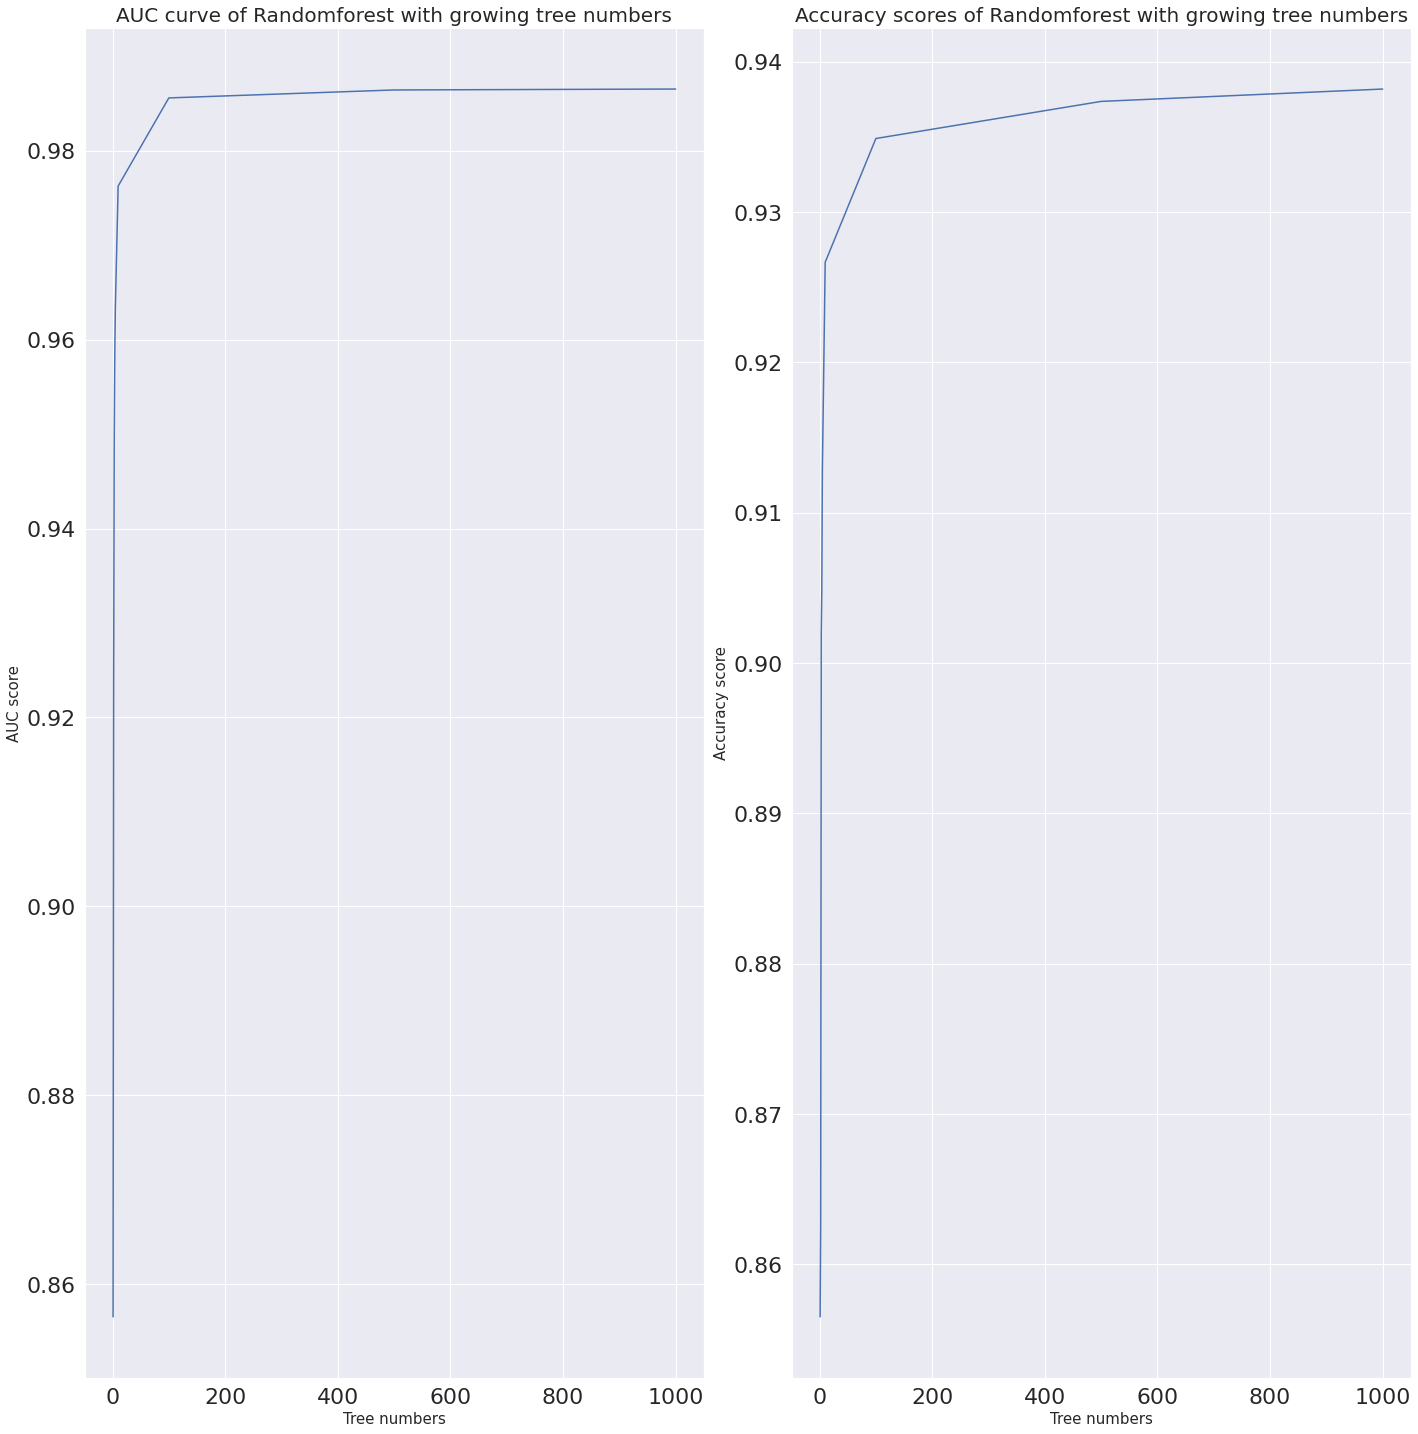

In [ ]:
 # Increase number of trees with splitted train and test set
n_tree_list = [1, 2, 3, 4, 5, 10, 100, 500, 1000]
auc_scores_list = []
accuracy_list = []

# Create RandomForestClassifier object with increasing number of trees
for tree_numb in n_tree_list:
  print('Tree number: {}'.format(tree_numb))
  randomfclf_sm = RandomForestClassifier(n_estimators=tree_numb, random_state=57)
  # Fit it to training data
  y_pred_prob_rtclf_sm = cross_val_predict(estimator=randomfclf_sm, X=stroke_df_norm_smote, y=y_all_smote, cv=5, method='predict_proba')
  y_pred_rtclf_sm = cross_val_predict(estimator=randomfclf_sm, X=stroke_df_norm_smote, y=y_all_smote, cv=5, method='predict')

  # Add auc score and accuracy to corresponding lists
  auc_scores_list.append(roc_auc_score(y_all_smote, y_pred_prob_rtclf_sm[:, 1]))
  accuracy_list.append(accuracy_score(y_all_smote, y_pred_rtclf_sm))



# Plot auc and accuracy with increasing number of trees in different subplot
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 20))
plt.tight_layout()
ax.plot(n_tree_list, auc_scores_list)
ax.set_title('AUC curve of Randomforest with growing tree numbers', fontsize=20)
ax.set_xlabel('Tree numbers', fontsize=15)
ax.set_ylabel('AUC score', fontsize=15)

ax2.plot(n_tree_list, accuracy_list)
ax2.set_title('Accuracy scores of Randomforest with growing tree numbers', fontsize=20)
ax2.set_xlabel('Tree numbers', fontsize=15)
ax2.set_ylabel('Accuracy score', fontsize=15)


# SVC

In [ ]:
# Build model default: rbf
svc = SVC(probability=True)
svc_smote = SVC(probability=True)

# Fit data
svc.fit(X_train, y_train)
svc_smote.fit(x_train_smote, y_train_smote)

# Predict probability and classes separately
y_pred_prob_svc = svc.predict_proba(X_test)
y_pred_prob_svc_smote = svc_smote.predict_proba(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_svc_smote = svc_smote.predict(X_test)

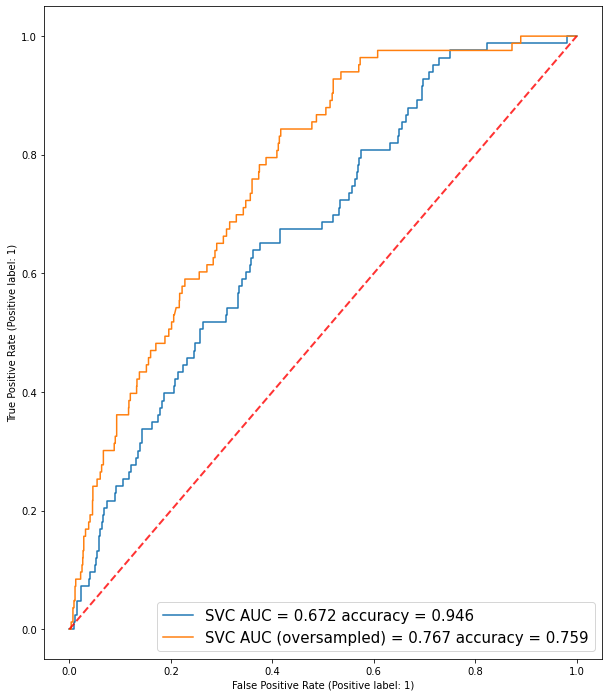

In [ ]:
# Plot ROC curves and accuracy
# Plot ROC curves with AUC score and accuracy score

fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(10)
RocCurveDisplay.from_predictions(y_test, y_pred_prob_svc[:, 1], ax=ax, label='SVC AUC = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_svc[:, 1]), accuracy_score(y_test, y_pred_svc)))
RocCurveDisplay.from_predictions(y_test, y_pred_prob_svc_smote[:, 1], ax=ax, label='SVC AUC (oversampled) = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_svc_smote[:, 1]), accuracy_score(y_test, y_pred_svc_smote)))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)
plt.legend(prop={'size':15})


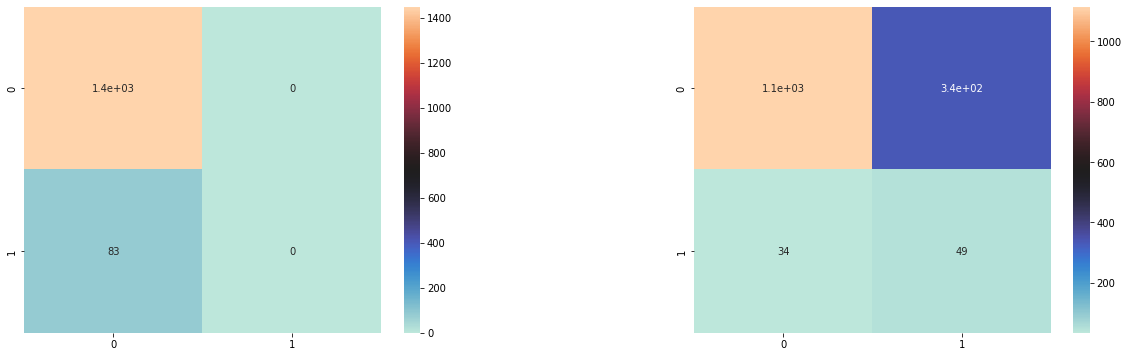

In [ ]:
# Confusion mattrix
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot=True, cmap='icefire', ax=ax[0])
sns.heatmap(confusion_matrix(y_test, y_pred_svc_smote), annot=True, cmap='icefire', ax=ax[1])
plt.subplots_adjust(wspace=0.5)

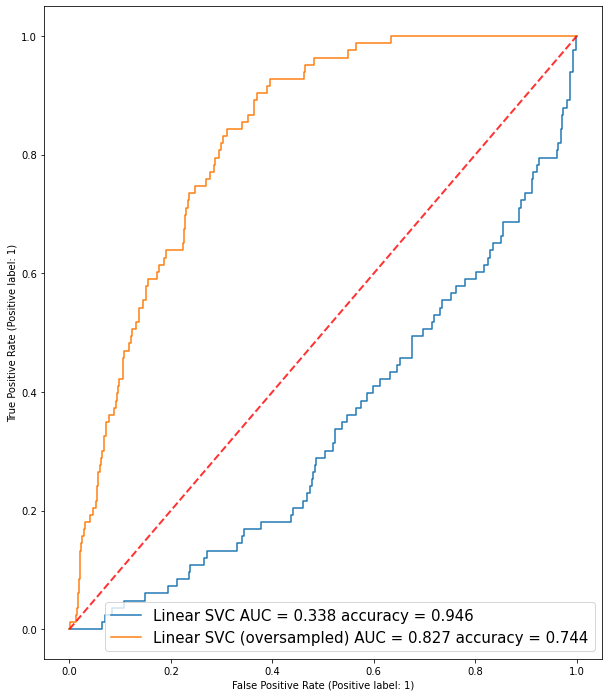

In [ ]:
# Build model linear
svc_lin = SVC(kernel='linear', probability=True)
svc_lin_smote = SVC(kernel='linear', probability=True)

# Fit data
svc_lin.fit(X_train, y_train)
svc_lin_smote.fit(x_train_smote, y_train_smote)

# Predict probability and classes separately
y_pred_prob_svc_lin = svc_lin.predict_proba(X_test)
y_pred_prob_svc_lin_smote = svc_lin_smote.predict_proba(X_test)
y_pred_svc_lin = svc_lin.predict(X_test)
y_pred_svc_lin_smote = svc_lin_smote.predict(X_test)

# Plot ROC curves and accuracy

fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(10)
RocCurveDisplay.from_predictions(y_test, y_pred_prob_svc_lin[:, 1], ax=ax, label='Linear SVC AUC = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_svc_lin[:, 1]), accuracy_score(y_test, y_pred_svc_lin)))
RocCurveDisplay.from_predictions(y_test, y_pred_prob_svc_lin_smote[:, 1], ax=ax, label='Linear SVC (oversampled) AUC = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_svc_lin_smote[:, 1]), accuracy_score(y_test, y_pred_svc_lin_smote)))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)
plt.legend(prop={'size':15})

In [ ]:
roc_auc_score(y_test, y_pred_prob_svc_lin[:, 1])

0.33828001661819695

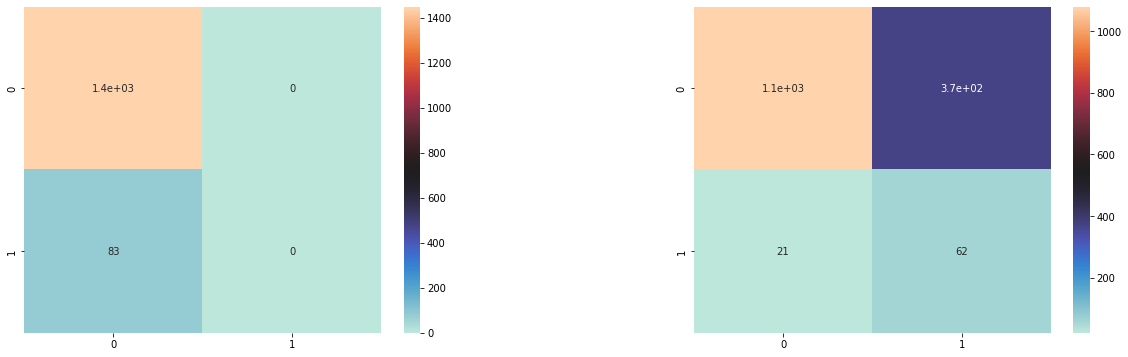

In [ ]:
# Confusion matrix linear svc
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svc_lin), annot=True, cmap='icefire', ax=ax[0])
sns.heatmap(confusion_matrix(y_test, y_pred_svc_lin_smote), annot=True, cmap='icefire', ax=ax[1])
plt.subplots_adjust(wspace=0.5)

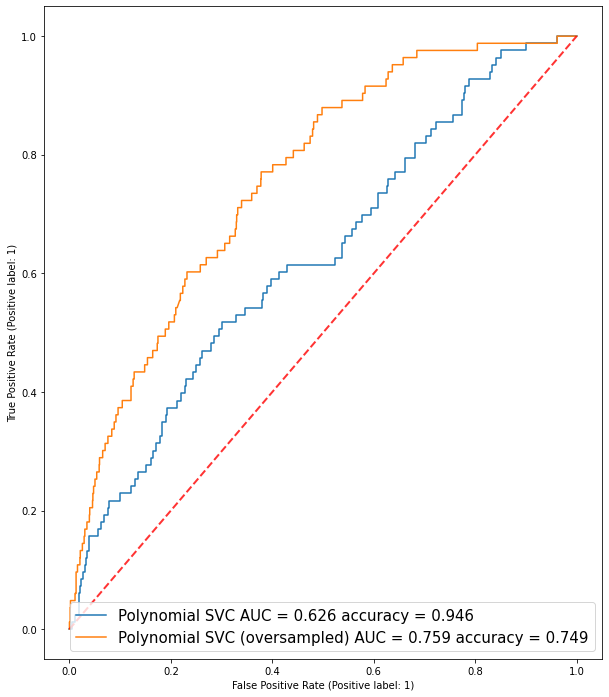

In [ ]:
# Build model polynomial
svc_poly = SVC(kernel='poly', probability=True)
svc_poly_smote = SVC(kernel='poly', probability=True)

# Fit data
svc_poly.fit(X_train, y_train)
svc_poly_smote.fit(x_train_smote, y_train_smote)

# Predict probability and classes separately
y_pred_prob_svc_poly = svc_poly.predict_proba(X_test)
y_pred_prob_svc_poly_smote = svc_poly_smote.predict_proba(X_test)
y_pred_svc_poly = svc_poly.predict(X_test)
y_pred_svc_poly_smote = svc_poly_smote.predict(X_test)

# Plot ROC curves and accuracy

fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(10)

RocCurveDisplay.from_predictions(y_test, y_pred_prob_svc_poly[:, 1], ax=ax, label='Polynomial SVC AUC = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_svc_poly[:, 1]), accuracy_score(y_test, y_pred_svc_poly)))
RocCurveDisplay.from_predictions(y_test, y_pred_prob_svc_poly_smote[:, 1], ax=ax, label='Polynomial SVC (oversampled) AUC = {:.3f} accuracy = {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_svc_poly_smote[:, 1]), accuracy_score(y_test, y_pred_svc_poly_smote)))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)
plt.legend(prop={'size':15})

In [ ]:
roc_auc_score(y_test, y_pred_prob_svc_poly[:, 1])

0.6256252596593269

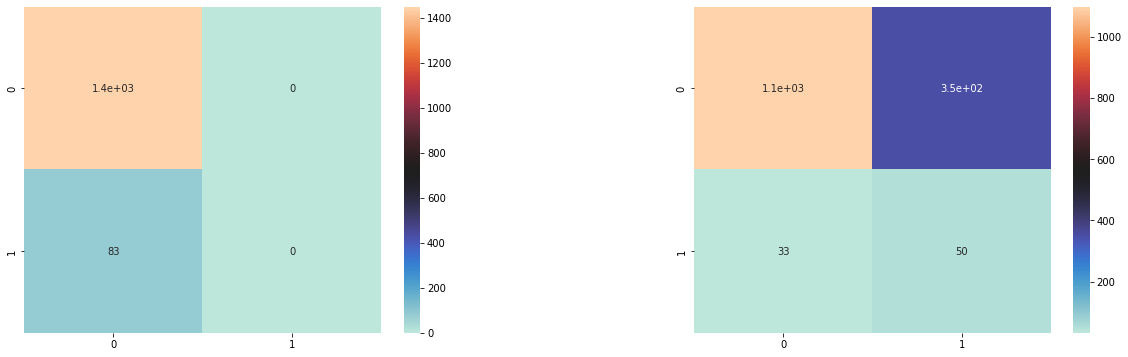

In [ ]:
# Confusion matrix polynomial rbf svc
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svc_poly), annot=True, cmap='icefire', ax=ax[0])
sns.heatmap(confusion_matrix(y_test, y_pred_svc_poly_smote), annot=True, cmap='icefire', ax=ax[1])
plt.subplots_adjust(wspace=0.5)